Created on Wed Nov 15 16:38:45 2023

Notebook for force measurement - article 0

1. import libraries
2. import main excel file
3. import tracking data (support position, contact position,2 stem points near support)
4. import results from root_stem_extractor
5. a. remove problematic events from raw data
5. b. note event types from excel: close2axis, multi-twine, simple twine/slip
6. populate event-class variables
9. figures:
    1. example: X,Y,Z position of support
    2. example: angle of support
    3. example: Force trajectory of 1 twine and 1 slip
    4. Force trajectories for different support masses
    5. dF/dt ? 
    6. Calibration graph


@author: Amir Ohad

In [1]:
#%% import libraries
# generic
import sys
import numpy as np
import os,glob # for listing files in folder
import re # regular expressions
import pandas as pd
import scipy
import seaborn
import math as m
from scipy.signal import savgol_filter
from scipy.spatial import distance as sci_distance
from scipy.stats import kruskal
import importlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
import random
import itertools
# from progress_bar import InitBar
from tqdm import tqdm
import pickle as pkl
import datetime
now = datetime.datetime.now()

# custom
import exp2funcs
# sys.path.append('..')
import useful_functions as uf 

# import error_estimates

#general parameters
cmap = plt.get_cmap('viridis')
# fs = 16 # standard font size for plots

# unit conversion for paper figures
dyne2mN = 1/100
mg2mN = 1/100
mg2uN = 1*10
print(os.getcwd())

importlib.reload(uf)
importlib.reload(exp2funcs)

save_folder = r'C:\Users\Amir\Documents\PHD\Thesis\My Articles\0 - Flexible dynamic force measurement method via physical pendulum\Images'


hi
c:\Users\Amir\Documents\PHD\Python\GitHub\Amir_Repositories\Repo_article0
hi


In [2]:
#%% import data 
root_path = r'C:\Users\Amir\Documents\PHD\Experiments\Force Measurements'
basepath = root_path+r'\Exp2_Pendulum' # pendulum exp folder
excel= r'\Exp2_supplementary_measurements_events.csv'

# straw exp data
data_panda = pd.read_csv(basepath+excel)


# import tracked data, initiate variables
track_sup_path = r'\track_logs'
track_folder_path = basepath+track_sup_path

track_contact_path = r'\contact_track_logs'
contact_folder_path = basepath+track_contact_path

track_near_sup_path = r'\twine_init_logs'
track_near_sup_folder_path = basepath+track_near_sup_path

h5_path = r'\Measurements\root_stem_results'
h5_folder_path = basepath+h5_path

E_path = r'\Young_moduli'
E_folder_path = basepath+E_path

N_track = len(os.listdir(track_folder_path)) # get number of files in track folder
N_contact=len(os.listdir(contact_folder_path)) # get number of files in contact folder
N_tot = len(data_panda) # get number of lines in excel
N_E = len(os.listdir(E_folder_path))


#%% remove problematic events from raw data
delete_rows = [] # save rows to delete
problem_exp = [] # exp_num of problem events

for i in range(N_tot): # remove problem events and non-Helda events
    if data_panda.at[i,'problem']!='na' or data_panda.at[i,'Bean_Strain']!='Helda':
        delete_rows.append(i)
        problem_exp.append(data_panda.at[i,'Exp_num'])
N = N_tot - len(delete_rows) # modify num of rows

data_panda = data_panda.drop(data_panda.index[delete_rows]) # remove prob. events
data_panda = data_panda.reset_index() # redo index
#%% get misc. file lists

# get track files for support bottom coordinates
remove_chars = re.compile('[,_\.!?]') # what to remove from strings
track_dict = {} # save support track in dictionary by exp and events
i=0 # start with first track file
for file in glob.glob(os.path.join(track_folder_path, '*.txt')): # for each event:
    exp = int(re.findall('_\d{3,4}_',file)[0].replace('_','')) # find exp number (3-4 digits)
    event = int(re.findall('[0-9]',re.findall('_\d{1}\D',file)[0].replace('_',''))[0]) # find event number
    viewt = re.findall('(side{1}|top{1})',file)[0] #.replace('_','')
    track_dict[(exp,event,viewt)] = [file] # add new exp
    i+=1

# get track files for stem-support contact coordinates
contact_dict = {} # save support contact track in dictionary by exp and events
i=0 # start with first contact file
for file in glob.glob(os.path.join(contact_folder_path, '*.txt')): # for each event:
    exp = int(re.findall('_\d{3,4}_',file)[0].replace('_','')) # find exp number (3-4 digits)
    event = int(re.findall('_[0-9]_',file)[0].replace('_','')) # find event number
    contact_dict[(exp,event)] = [file] # add new exp
    i+=1

# get track files for 2 stem positions on either side of support
near_sup_track_dict = {}
i=0 # start with first stem_near_sup file
for file in glob.glob(os.path.join(track_near_sup_folder_path, '*.txt')): # for each event:
    exp = int(re.findall('_\d{3,4}_',file)[0].replace('_','')) # find exp number (3-4 digits)
    event = int(re.findall('_[0-9]_',file)[0].replace('_','')) # find event number
    near_sup_track_dict[(exp,event)] = [file] # add new exp
    i+=1

# get h5 files for stem near support
h5_dict = {}
i=0 # start with first h5 file
for file in glob.glob(os.path.join(h5_folder_path, '*.h5')): # for each event:
    exp = int(re.findall('interekt_\d{2,3}_',file)[0].split('_')[1]) # find exp number (3-4 digits)
    event = int(re.findall('e_[0-9]_',file)[0].split('_')[1]) # find event number
    start_frame = int(re.findall('_\d{2,5}-\d{2,5}',file)[0].replace('_','').split('-')[0]) # find start frame
    h5_dict[(exp,event,start_frame)] = [file] # add new exp
    i+=1

# get Young modulus files
E_dict = {}
for file in glob.glob(os.path.join(E_folder_path, '*.csv')):
    exp = int(re.findall('\d{2,3}',file)[0])
    E_dict[exp]=pd.read_csv(file,header=None)

#%%

In [4]:
#%% clear plants and events
plants = []
events = []
#%% populate plant and event instances
i = 0
N = len(data_panda)
for i in tqdm(range(N)): # N
    exp = int(re.findall('\d{3,4}',data_panda.at[i,'Exp_num'])[0]) # exp num
    view = data_panda.at[i,'View']  # side of top view
    if view == 'top':
        plants[-1].pix2cm_t = float(data_panda.at[i,'Top_pix2cm'])

    if i==0 or exp!=plants[-1].exp_num: # append new plant with data from pandas
        #basic data
        plants.append(exp2funcs.Plant(data_panda,basepath,i,exp))
        # view dependent data
        plants[-1].view_data(data_panda,i)
        # circumnutation data
        plants[-1].cn_data(data_panda,i)
        #Youngs modulus by segment with avg
        plants[-1].getE(E_dict)


    event =  int(re.findall('_[0-9]',data_panda.at[i,
       'Exp_num'])[0].replace('_','')) # get event number


    # if this is the 1st event or the previous event_num is different from the current one:
    # add new event to list
    if len(events)==0 or events[-1].event_num != event or \
        events[-1].p.exp_num != exp:
        events.append(exp2funcs.Event(plants[-1],data_panda,i))
    events[-1].event_num = event

    # view dependent data
    events[-1].view_data(data_panda,i,view)

    # get automated extraction of twine(decision) time
    events[-1].get_twine_time(exp,event,view,
                      h5_dict,near_sup_track_dict,50,track_dict,to_plot=0)


    # get track data, select decision period data, pix2cm,
    events[-1].event_base_calcs(view,track_dict,contact_dict)
    # calc
    events[-1].event_calc_variables(view)
    # print(f'i={i}, exp number {exp}, {event}') # print progress


100%|██████████| 264/264 [00:12<00:00, 20.95it/s]


twine:True
slip:True


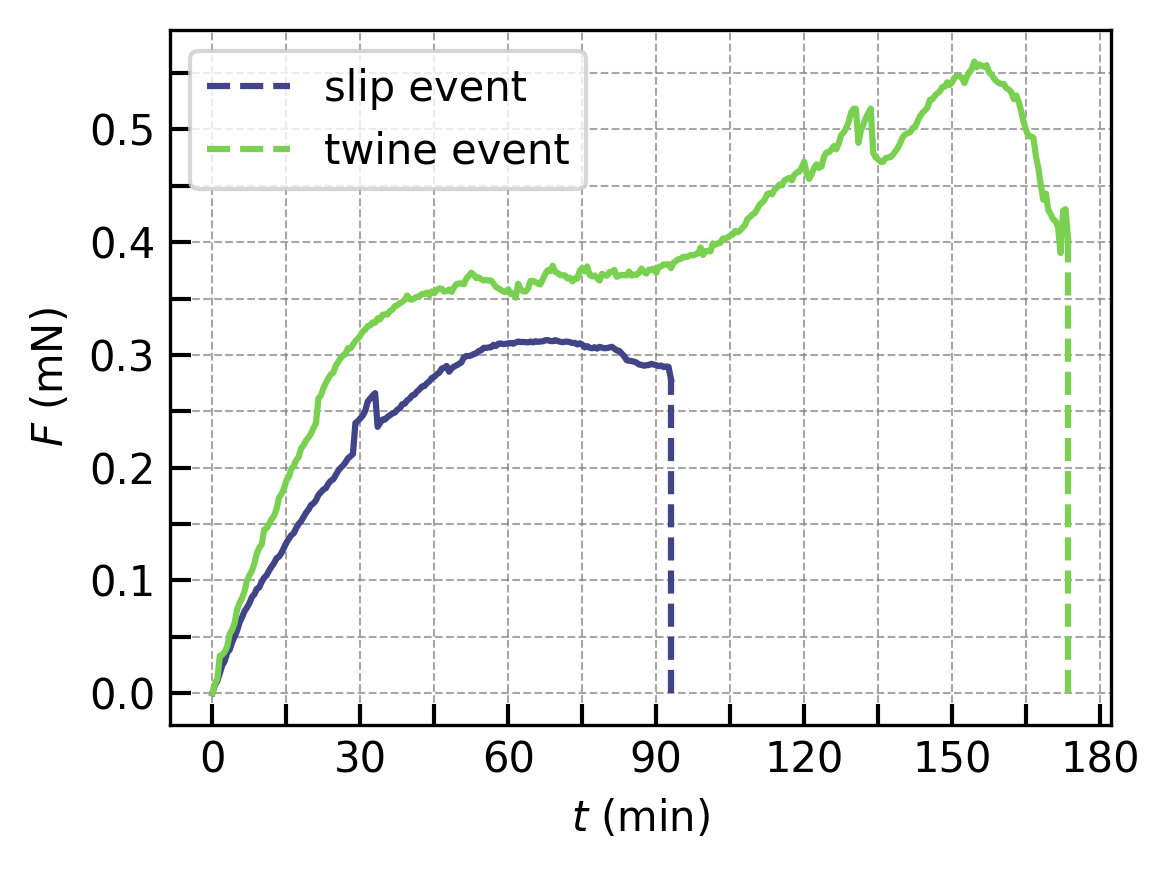

In [11]:
# slip and twine trajectories - old calculation
i_slip = 26
i_twine = 41
fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=300)

# converting force in mg to mN
# plt.plot(events[i_slip].timer/60,np.multiply(events[i_slip].F_bean,mg2mN),
#          color=cmap(0.2))
# plt.plot(events[i_twine].timer/60,np.multiply(events[i_twine].F_bean,mg2mN),
#          color=cmap(0.8))
# presenting force in mg
plt.plot(events[i_slip].timer/60,events[i_slip].F_bean,color=cmap(0.2))
plt.plot(events[i_twine].timer/60,events[i_twine].F_bean,color=cmap(0.8))
plt.xlabel(r'$t$ (min)') #,fontsize=fs)
plt.ylabel(r'$F$ (mN)') #,fontsize=fs)
# plt.legend(['twine event','slip event'])
plt.vlines(events[i_slip].timer[-1]/60, 0,
           events[i_slip].F_bean[-1], color=cmap(0.2),
           linestyle='dashed',label='slip event')
plt.vlines(events[i_twine].timer[-1]/60, 0,
           events[i_twine].F_bean[-1], color=cmap(0.8),
           linestyle='dashed',label='twine event')
plt.legend()

print("twine:"+ str(events[i_twine].twine_state==1))
print("slip:"+ str( events[i_slip].twine_state==0))

uf.set_grid(plt.gca(),150,0.5)
plt.tight_layout()
plt.show()
fig.savefig(save_folder+r'\twine_slip_events.png',dpi=300)

twine:True
slip:True


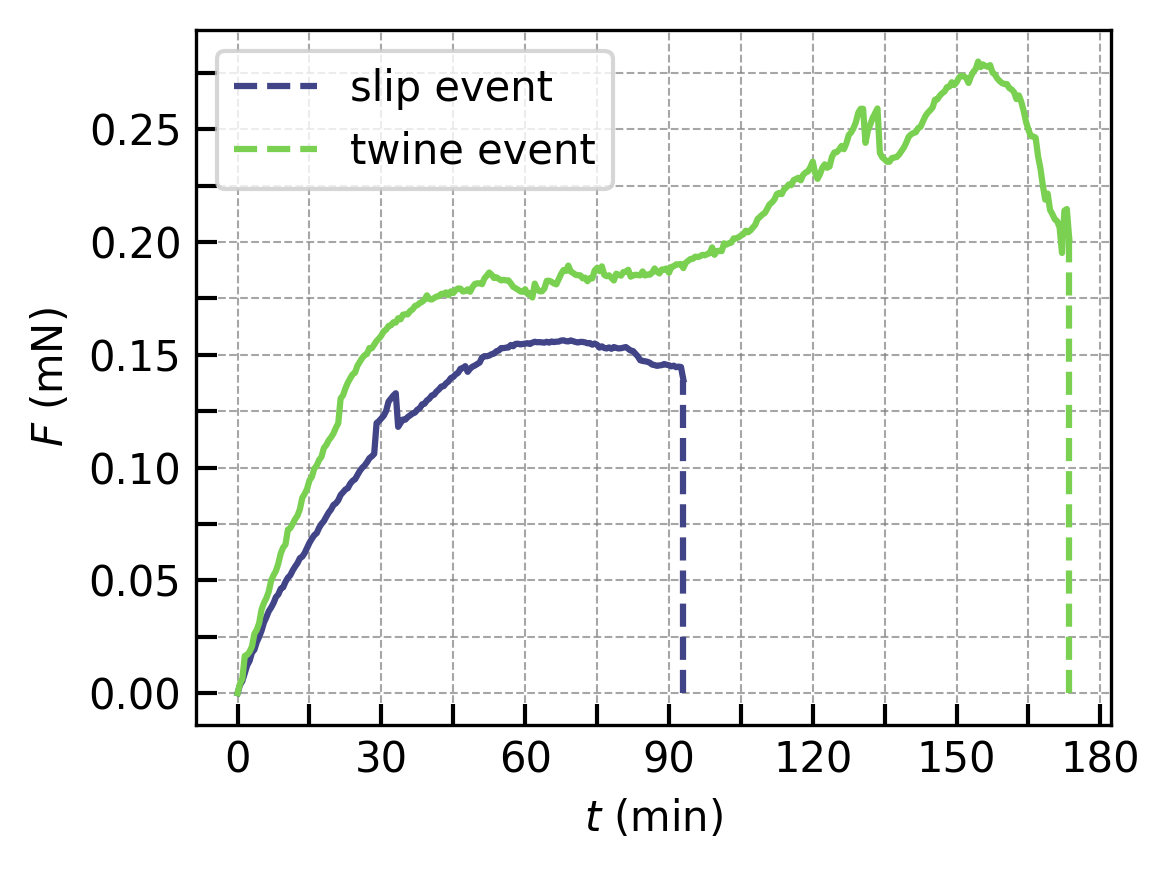

In [ ]:
# slip and twine trajectories - calculation v2
i_slip = 26
i_twine = 41
fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=300)

# converting force in mg to mN
# plt.plot(events[i_slip].timer/60,np.multiply(events[i_slip].F_bean,mg2mN),
#          color=cmap(0.2))
# plt.plot(events[i_twine].timer/60,np.multiply(events[i_twine].F_bean,mg2mN),
#          color=cmap(0.8))
# presenting force in mg
plt.plot(events[i_slip].timer/60,events[i_slip].F_bean2,color=cmap(0.2))
plt.plot(events[i_twine].timer/60,events[i_twine].F_bean2,color=cmap(0.8))
plt.xlabel(r'$t$ (min)') #,fontsize=fs)
plt.ylabel(r'$F$ (mN)') #,fontsize=fs)
# plt.legend(['twine event','slip event'])
plt.vlines(events[i_slip].timer[-1]/60, 0,
           events[i_slip].F_bean2[-1], color=cmap(0.2),
           linestyle='dashed',label='slip event')
plt.vlines(events[i_twine].timer[-1]/60, 0,
           events[i_twine].F_bean2[-1], color=cmap(0.8),
           linestyle='dashed',label='twine event')
plt.legend()

print("twine:"+ str(events[i_twine].twine_state==1))
print("slip:"+ str( events[i_slip].twine_state==0))

uf.set_grid(plt.gca(),150,0.25)
plt.tight_layout()
plt.show()
fig.savefig(save_folder+r'\twine_slip_events2.png',dpi=300)

Twine:True
Slip:True


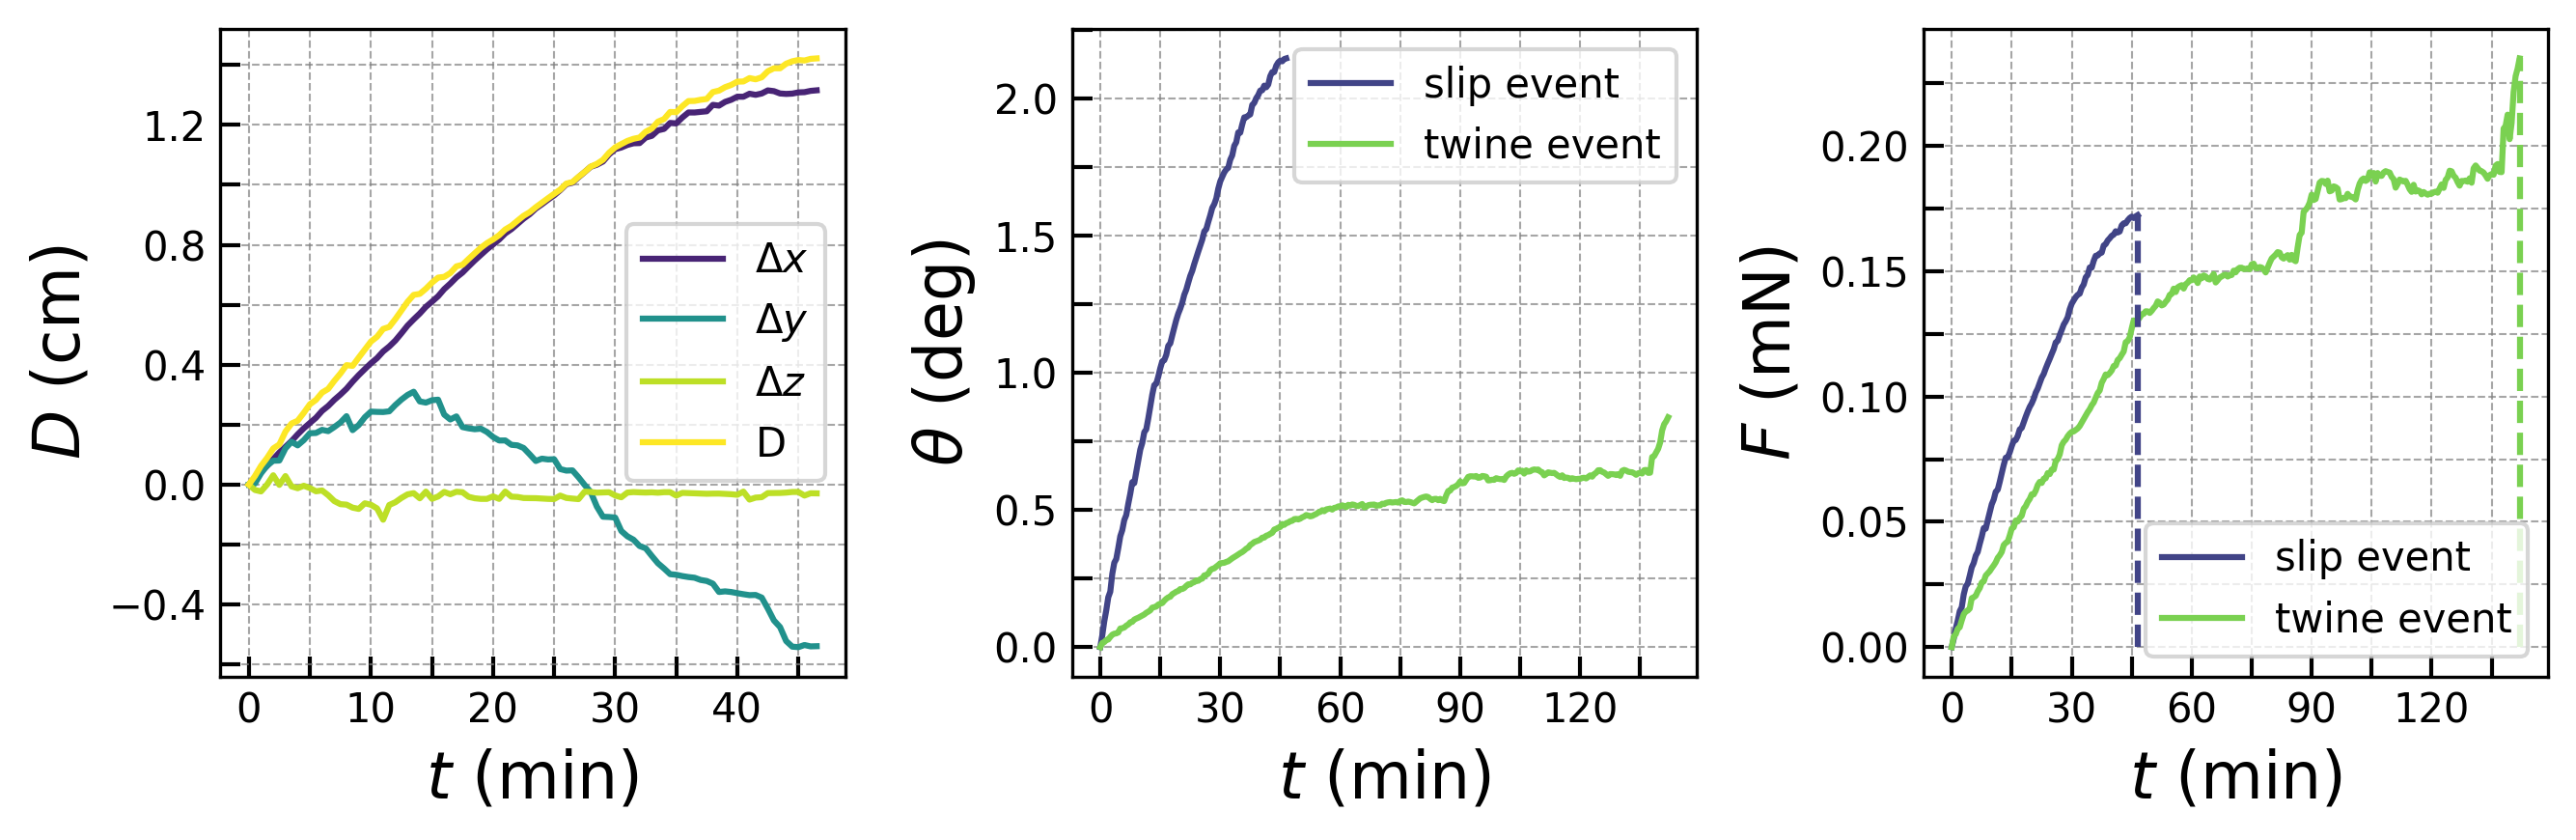

16


In [6]:
#%% figure - Force trajectory of 1 twine and 1 slip
cmap = plt.get_cmap('viridis')
fs = 1
i_slip = 40
i_twine = 50

# check events are correctly classified
print("Twine:"+ str(events[i_twine].twine_state==1))
print("Slip:"+ str( events[i_slip].twine_state==0))

fig, axs = plt.subplots(1, 3, figsize=(9, 3),dpi=300)

# Plot xyz coordinates
xyz = events[i_slip].xyz
axs[0].plot(events[i_slip].timer/60, xyz[0,::]-xyz[0,0], color=cmap(0.1), label=r'$\Delta x$')
axs[0].plot(events[i_slip].timer/60, xyz[1,::]-xyz[1,0], color=cmap(0.5), label='$\Delta y$')
axs[0].plot(events[i_slip].timer/60, xyz[2,::]-xyz[2,0], color=cmap(0.9), label='$\Delta z$')
axs[0].plot(events[i_slip].timer/60, events[i_slip].trk_dist, color=cmap(1.5), label='D')
axs[0].set_xlabel(r'$t$ (min)', fontsize=fs)
axs[0].set_ylabel(r'$D$ (cm)', fontsize=fs)
axs[0].legend()


# Plot angle
axs[1].plot(events[i_slip].timer/60, np.rad2deg(events[i_slip].alpha), color=cmap(0.2), label='slip event')
axs[1].plot(events[i_twine].timer/60, np.rad2deg(events[i_twine].alpha), color=cmap(0.8), label='twine event')
axs[1].set_xlabel(r'$t$ (min)', fontsize=fs)
axs[1].set_ylabel(r'$\alpha$ (deg)', fontsize=fs)
axs[1].legend()

# Plot calculated force
axs[2].plot(events[i_slip].timer/60, np.multiply(events[i_slip].F_bean, mg2mN), color=cmap(0.2),label='slip event')
axs[2].plot(events[i_twine].timer/60, np.multiply(events[i_twine].F_bean, mg2mN), color=cmap(0.8),label='twine event')
axs[2].set_xlabel(r'$t$ (min)', fontsize=fs)
axs[2].set_ylabel(r'$F$ (mN)', fontsize=fs)
axs[2].legend()
axs[2].vlines(events[i_slip].timer[-1]/60, 0, events[i_slip].F_bean[-1]*mg2mN, color=cmap(0.2), linestyle='dashed')
axs[2].vlines(events[i_twine].timer[-1]/60, 0, events[i_twine].F_bean[-1]*mg2mN, color=cmap(0.8), linestyle='dashed')

uf.set_grid(axs[0],50,2)
uf.set_grid(axs[1],150,2.5)
uf.set_grid(axs[2],150,0.25)

plt.tight_layout()
plt.show()
print(fs)
fig.savefig(save_folder+r'\xyz_angle_force2.png',dpi=300)

Slip:True


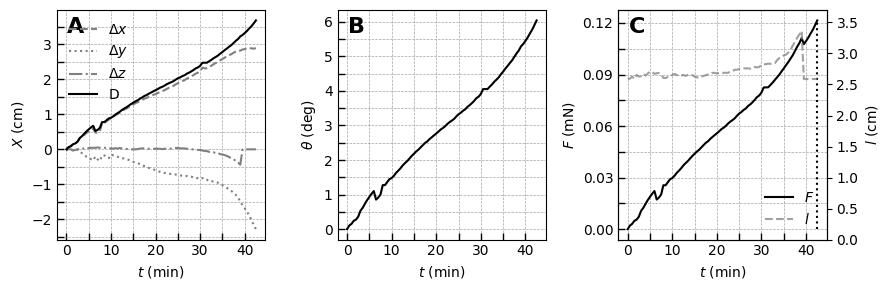

In [ ]:
#%% figure - Force trajectory for slip event with contact position along support 1
# cmap = plt.get_cmap('viridis')
cmap = plt.get_cmap('rainbow')
fs= 16
i_slip = 120 # 40 (simple) , 20,120 (bump from dist2tip)

# check events are correctly classified
print("Slip:"+ str( events[i_slip].twine_state==0))

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add subplot labels
axs[0].text(0.05, 0.9, 'A', fontsize=fs, fontweight='bold', transform=axs[0].transAxes)
axs[1].text(0.05, 0.9, 'B', fontsize=fs, fontweight='bold', transform=axs[1].transAxes)
axs[2].text(0.05, 0.9, 'C', fontsize=fs, fontweight='bold', transform=axs[2].transAxes)

# Plot xyz coordinates
xyz = events[i_slip].xyz
axs[0].plot(events[i_slip].timer/60, xyz[0,::]-xyz[0,0], color='gray', linestyle = 'dashed', label=r'$\Delta x$') #cmap(0.1)
axs[0].plot(events[i_slip].timer/60, xyz[1,::]-xyz[1,0], color='gray', linestyle = 'dotted', label=r'$\Delta y$') #cmap(0.5)
axs[0].plot(events[i_slip].timer/60, xyz[2,::]-xyz[2,0], color='gray', linestyle = 'dashdot', label=r'$\Delta z$') #cmap(0.9)
axs[0].plot(events[i_slip].timer/60, events[i_slip].trk_dist, color='black', label='D') #cmap(1.5)

# Plot angle
axs[1].plot(events[i_slip].timer/60, np.rad2deg(events[i_slip].alpha), color='black', label='slip event') #cmap(0.2)
# axs[1].legend(fontsize = fs)

# Plot calculated force
# Combine legends from both axes

axs[2].plot(events[i_slip].timer/60, np.multiply(events[i_slip].F_bean, mg2mN), color='black', label=r'$F$') #cmap(0.2)
ax2 = axs[2].twinx()
dist2tip = [abs(k) for k in events[i_slip].L_contact2suptip]
# ax2.plot(events[i_slip].timer/60, dist2tip, color='gray', label=r'$l$', alpha=0.75) # cmap(0.7)

axs[2].vlines(events[i_slip].timer[-1]/60, 0, events[i_slip].F_bean[-1]*mg2mN, color='black', linestyle='dotted')
ax2.plot(events[i_slip].timer/60, dist2tip, color='gray', linestyle='dashed', label=r'$l$', alpha=0.75)
lines, labels = axs[2].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axs[2].legend(lines + lines2, labels + labels2, loc='best',frameon=False)

# set axis labels and grid
axs[0].set_xlabel(r'$t$ (min)')
axs[0].set_ylabel(r'$X$ (cm)')
axs[0].legend(loc='best',frameon=False)
uf.set_grid(axs[0],50,5)

axs[1].set_xlabel(r'$t$ (min)')
axs[1].set_ylabel(r'$\alpha$ (deg)')
uf.set_grid(axs[1],50,5)

ax2.set_ylabel(r'$l$ (cm)')
ax2.set_ylim([0,max(dist2tip)*1.1])
axs[2].set_xlabel(r'$t$ (min)')
axs[2].set_ylabel(r'$F$ (mN)')
uf.set_grid(axs[2],50,0.15)
# ax2.tick_params(labelsize=fs-2)
# uf.set_grid(ax2,50,4)

plt.tight_layout()
plt.show()
fig.savefig(save_folder+r'\xyz_ang_F_l.png',dpi=300)


Slip:True


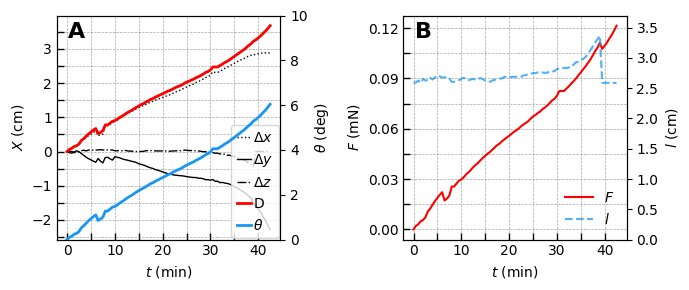

In [28]:
#%% figure - Force trajectory for slip event with contact position along support 2
# cmap = plt.get_cmap('viridis')
cmap = plt.get_cmap('rainbow')
fs= 16
i_slip = 120 # 40 (simple) , 20,120 (bump from dist2tip)

# check events are correctly classified
print("Slip:"+ str( events[i_slip].twine_state==0))

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
# add subplot labels
axs[0].text(0.05, 0.9, 'A', fontsize=fs, fontweight='bold', transform=axs[0].transAxes)
axs[1].text(0.05, 0.9, 'B', fontsize=fs, fontweight='bold', transform=axs[1].transAxes)

# Plot xyz coordinates
xyz = events[i_slip].xyz
axs[0].plot(events[i_slip].timer/60, xyz[0,::]-xyz[0,0], color='black', 
            linestyle = 'dotted', linewidth = 1, label=r'$\Delta x$') #cmap(0.1)
axs[0].plot(events[i_slip].timer/60, xyz[1,::]-xyz[1,0], color='black', 
            linestyle = '-', linewidth = 1, label=r'$\Delta y$') #cmap(0.5)
axs[0].plot(events[i_slip].timer/60, xyz[2,::]-xyz[2,0], color='black', 
            linestyle = 'dashdot', linewidth = 1, label=r'$\Delta z$') #cmap(0.9)
axs[0].plot(events[i_slip].timer/60, events[i_slip].trk_dist, color=cmap(1.5), linewidth = 2, label = 'D') #cmap(1.5)

# Plot angle on the same figure with different axis
axs0 = axs[0].twinx()
axs0.plot(events[i_slip].timer/60, np.rad2deg(events[i_slip].alpha), color=cmap(0.2), linewidth = 2, label=r'$\alpha$') #cmap(0.2)
# add legend label from the twin axis
lines, labels = axs[0].get_legend_handles_labels()
lines2, labels2 = axs0.get_legend_handles_labels()

# set axis and grid
axs[0].set_xlabel(r'$t$ (min)')
axs[0].set_ylabel(r'$X$ (cm)')
axs0.set_ylim([0,10])
uf.set_grid(axs[0],50,5)

# axs0.set_xlabel(r'$t$ (min)')
axs0.set_ylabel(r'$\alpha$ (deg)')

# Adjust the legend properties

axs[0].legend(
    lines + lines2, labels + labels2,
    loc='lower right',          # Place legend
    frameon=True,              # Remove the frame
    handlelength=1,             # Shorter line elements
    handletextpad=0.2,          # Reduce space between handle and text
    borderaxespad=0.1,          # Reduce space between legend and inset plot edge
    fontsize=10                 # Smaller font size for better fit
)


###########################################
# Plot calculated force and contact position

axs[1].plot(events[i_slip].timer/60, np.multiply(events[i_slip].F_bean, mg2mN),
             color=cmap(1.5), label=r'$F$') #cmap(0.2)
ax2 = axs[1].twinx()
dist2tip = [abs(k) for k in events[i_slip].L_contact2suptip]
# ax2.plot(events[i_slip].timer/60, dist2tip, color='gray', label=r'$l$', alpha=0.75) # cmap(0.7)

# axs[1].vlines(events[i_slip].timer[-1]/60, 0, events[i_slip].F_bean[-1]*mg2mN,
#                color=cmap(1.5), linestyle='dotted')
ax2.plot(events[i_slip].timer/60, dist2tip, color= cmap(0.2), linestyle='dashed',
          label=r'$l$', alpha=0.75)
lines, labels = axs[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axs[1].legend(lines + lines2, labels + labels2, loc='best',frameon=False)

ax2.set_ylabel(r'$l$ (cm)')
ax2.set_ylim([0,max(dist2tip)*1.1])
axs[1].set_xlabel(r'$t$ (min)')
axs[1].set_ylabel(r'$F$ (mN)')
uf.set_grid(axs[1],50,0.15)

plt.tight_layout()
plt.show()
fig.savefig(save_folder+r'\xyz_ang_F_l_2.png',dpi=300)

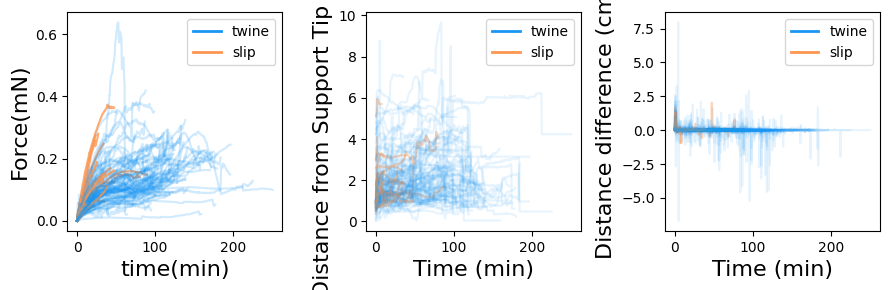

In [29]:
#%%  Force trajectory for slip event with contact position and difference along support (slip vs twine)
from matplotlib.lines import Line2D
savep = 0
legend_elements = [Line2D([0], [0], color=cmap(0.2), lw=2, label='twine'),
                   Line2D([0], [0], color=cmap(0.8), lw=2, label='slip')]
# Create the figure
fig, axs = plt.subplots(1, 3, figsize=(9, 3))

# S1- all twine/slip events
for i in range(len(events)):
    # Tcn = events[i].Tcn
    if events[i].twine_state==1:
        axs[0].plot(events[i].timer/60,np.multiply(events[i].F_bean,mg2mN),
                 color=cmap(0.2),alpha=0.2)
    if events[i].twine_state==0:
        axs[0].plot(events[i].timer[:-7]/60,np.multiply(events[i].F_bean[:-7],mg2mN),
                 color=cmap(0.8),alpha=0.8)
axs[0].set_xlabel('time(min)',fontsize=fs)
axs[0].set_ylabel('Force(mN)',fontsize=fs)
axs[0].legend(handles=legend_elements, loc='best')

#%% S2- contact distance from tip for all events
for i in range(len(events)):
    dist2tip = [abs(k) for k in events[i].L_contact2suptip]
    if events[i].twine_state==1:
        axs[1].plot(events[i].timer/60, dist2tip, color=cmap(0.2),alpha=0.1)
    if events[i].twine_state==0:
        axs[1].plot(events[i].timer[:-7]/60, dist2tip[:-7], color=cmap(0.8),alpha=0.4)
axs[1].set_ylabel('Distance from Support Tip (cm)', fontsize=fs)
axs[1].set_xlabel('Time (min)', fontsize=fs)
axs[1].legend(handles=legend_elements, loc='best')

#%% S3- change of contact distance from tip for all events
for i in range(len(events)):
        diff_dist2tip = np.diff([abs(k) for k in events[i].L_contact2suptip])
        if events[i].twine_state==1:
            axs[2].plot(events[i].timer[:-1]/60, diff_dist2tip, color=cmap(0.2),alpha=0.1)
        if events[i].twine_state==0:
            axs[2].plot(events[i].timer[:-8]/60, diff_dist2tip[:-7], color=cmap(0.8),alpha=0.4)
axs[2].set_ylabel('Distance difference (cm)', fontsize=fs)
axs[2].set_xlabel('Time (min)', fontsize=fs)
axs[2].legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()



NameError: name 'fs' is not defined

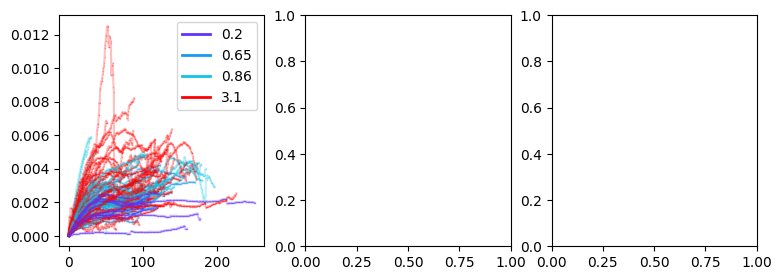

In [15]:
#%% Force trajectory for slip event with contact position and difference along support (support masses)
from matplotlib.lines import Line2D
cmap = plt.get_cmap('rainbow')
mass = [0.2,0.65,0.86,3.1]

# Create the figure
fig, axs = plt.subplots(1, 3, figsize=(9, 3)) # figsize=(15, 5)?

# S1- all events
for i in range(len(events)):
    if events[i].p.m_sup in mass:
        index = mass.index(events[i].p.m_sup)
        axs[0].plot(events[i].timer/60, np.multiply(events[i].F_bean,mg2mN),marker=
                    'x',markersize=0.5,color=cmap(mass[index]/max(mass)),alpha=0.25)

legend_elements = [Line2D([0], [0], color=cmap(mass[i]/max(mass)), lw=2, label=f'{mass[i]}') for i in range(len(mass))]
axs[0].legend(handles=legend_elements, loc='best')
axs[0].set_xlabel('time(min)',fontsize=fs)
axs[0].set_ylabel('Force(mN)',fontsize=fs)

# #%% S2- contact distance from tip for all events
for i in range(len(events)):
    dist2tip = [abs(k) for k in events[i].L_contact2suptip]
    if events[i].p.m_sup in mass:
        index = mass.index(events[i].p.m_sup)
        axs[1].plot(events[i].timer/60, dist2tip, marker=
                    'x',markersize=0.5,color=cmap(mass[index]/max(mass)),alpha=0.25)
legend_elements = [Line2D([0], [0], color=cmap(mass[i]/max(mass)), lw=2, label=f'{mass[i]}') for i in range(len(mass))]
axs[1].legend(handles=legend_elements, loc='best')
axs[1].set_ylabel('Distance from Support Tip (cm)', fontsize=fs)
axs[1].set_xlabel('Time (min)', fontsize=fs)

# #%% S3- change of contact distance from tip for all events #   
for i in range(len(events)):
    diff_dist2tip = np.diff([abs(k) for k in events[i].L_contact2suptip])    
    if events[i].p.m_sup in mass:
        index = mass.index(events[i].p.m_sup)
        axs[2].plot(events[i].timer[:-8]/60, diff_dist2tip[:-7], marker=
                'x',markersize=0.5,color=cmap(mass[index]/max(mass)),alpha=0.25)
legend_elements = [Line2D([0], [0], color=cmap(mass[i]/max(mass)), lw=2, label=f'{mass[i]}') for i in range(len(mass))]
axs[2].legend(handles=legend_elements, loc='best')
axs[2].set_ylabel('Distance difference (cm)', fontsize=fs)
axs[2].set_xlabel('Time (min)', fontsize=fs)

uf.set_grid(axs[0],250,0.7)
uf.set_grid(axs[1],250,10)
uf.set_grid(axs[2],250,15)

plt.tight_layout()
plt.show()


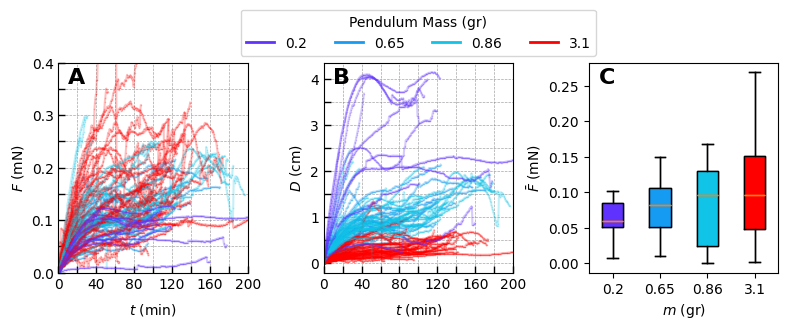

In [31]:
#%% Force trajectory and max force distributions per support masses 1
from matplotlib.lines import Line2D

cmap = plt.get_cmap('rainbow')
mass = [0.2,0.65,0.86,3.1] # current version
# mass = [0.2,0.65,0.86,1.1, 3.1] # check


# Create the figure
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
fig.align_labels()  # Align labels for all subplots
# add subplot labels
axs[0].text(0.05, 0.9, 'A', fontsize=fs, fontweight='bold', transform=axs[0].transAxes)
axs[1].text(0.05, 0.9, 'B', fontsize=fs, fontweight='bold', transform=axs[1].transAxes)
axs[2].text(0.05, 0.9, 'C', fontsize=fs, fontweight='bold', transform=axs[2].transAxes)

# S1- all events forces
for i in range(len(events)):
    if events[i].p.m_sup in mass:
        index = mass.index(events[i].p.m_sup)
        axs[0].plot(events[i].timer/60, np.multiply(events[i].F_bean,mg2mN),marker=
                    'x',markersize=0.5,color=cmap(mass[index]/max(mass)),alpha=0.25)

legend_elements = [Line2D([0], [0], color=cmap(mass[i]/max(mass)), lw=2, label=f'{mass[i]}') for i in range(len(mass))]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1), ncol=4, title='Pendulum Mass (gr)')

# S2- all events displacements
for i in range(len(events)):
    if events[i].p.m_sup in mass:
        index = mass.index(events[i].p.m_sup)
        axs[1].plot(events[i].timer/60, events[i].trk_dist ,marker=
                    'x',markersize=0.5,color=cmap(mass[index]/max(mass)),alpha=0.25)

# S3- mean force boxplot for all events (upto the first 2 hours)
f_mean = [[] for i in range(len(mass))]
for i in range(len(events)):
    
    if events[i].p.m_sup in mass:
        index = mass.index(events[i].p.m_sup)
        f_mean[index].append(np.mean(np.multiply(events[i].F_bean,mg2mN)))


axs[2].boxplot(f_mean, positions=range(len(mass))) # to space the ticks by mass
box_colors = [cmap(mass[i] / max(mass)) for i in range(len(mass))]
box = axs[2].boxplot(f_mean, patch_artist=True, positions=range(len(mass)))
for patch, color in zip(box['boxes'], box_colors):
    patch.set_facecolor(color)

# adjust limits and grid

axs[0].set_xlim([0,200])
axs[0].set_ylim([0,0.4])
axs[0].set_xlabel(r'$t$ (min)')
axs[0].set_ylabel(r'$F$ (mN)')
uf.set_grid(axs[0],200,0.5)

uf.set_grid(axs[1],200,5)
axs[1].set_xlim([0,200])
axs[1].set_xlabel(r'$t$ (min)')
axs[1].set_ylabel(r'$D$ (cm)') #,fontsize=fs)

axs[2].set_xticks(range(len(mass)))
axs[2].set_xticklabels([f'{m}' for m in mass], rotation=0)#, ha='right')
axs[2].set_ylabel(r'$\bar{F}$ (mN)')
axs[2].set_xlabel(r'$m$ (gr)')
# axs[2].set_xticks(mass)
# axs[2].set_xticklabels([f'{m}g' for m in mass], rotation=45, ha='right')

# adjust layout and show
fig.subplots_adjust(wspace=0.4)  # Adjust the width space between subplotsplt.tight_layout()
fig.subplots_adjust(top=0.8, bottom=0.1, left=0.1, right=0.9)  # Adjust as necessary

plt.show()
# fig.savefig(save_folder+r'\F_D_Fmean_msup.png',dpi=300)


min(a)=74.0,max(a)=195.625


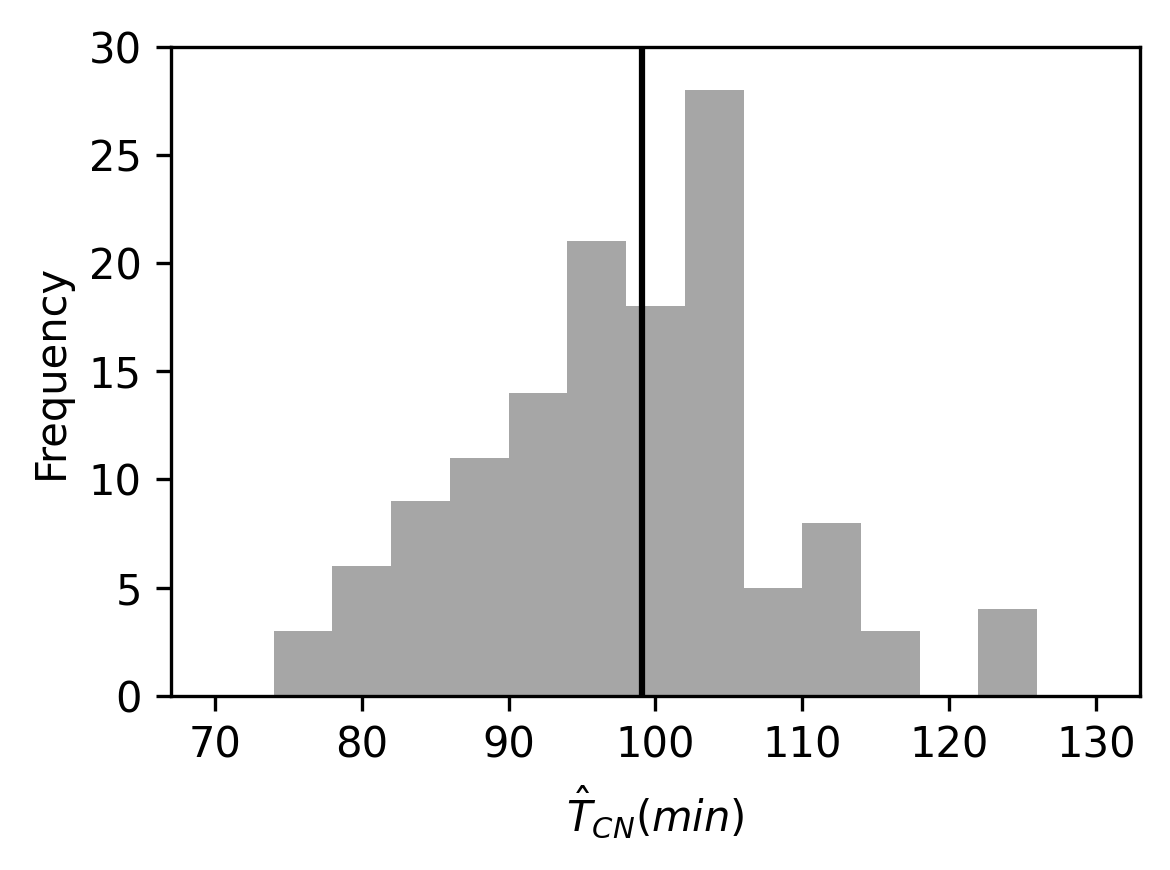

In [32]:
#%% plot T_cn distribution
# this is for plants of l_arm ~ 10-20 cm
cmap = plt.get_cmap('rainbow')
fig,ax = plt.subplots(1,1, figsize=(4, 3),dpi = 300)
a = []
nbin = 15
for i in range(len(events)):
    a.append(events[i].p.avgT)
bin_range = [70,130]

n = plt.hist(a,bins=nbin,range=bin_range,color = 'gray',alpha=0.7)
plt.xlabel(r'$\hat{T}_{CN}(min)$') #,fontsize=fs)
plt.ylabel(r'Frequency')#,fontsize=fs)
plt.vlines(np.mean(a), 0, 1.1*max(a),'k')
plt.ylim([0,30])
print(f'{min(a)=},{max(a)=}')

# uf.set_grid(plt.gca(),50,25)
plt.tight_layout()
plt.show()
fig.savefig(save_folder+r'\CN_dist.png',dpi=300)


C:\Users\Amir\AppData\Local\Temp\ipykernel_25024\1134819665.py:71: RuntimeWarning: invalid value encountered in divide
  ratio = (hist_slip[0] - hist_twine[0] )/ (hist_slip[0] + hist_twine[0] )


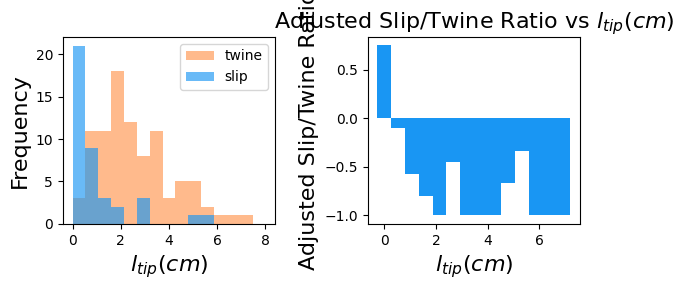

check high (var) values for slip events


In [33]:
#%% twine/slip probability graphs
var_slip = []
var_twine = []
var_name = [r'$\int\epsilon_{max}dt$ (sec)',r'$\epsilon_{max}$',
            r'$\int Fdt (mgf*sec)$', r'$T_{dec}/T_{cn}$','W(Fmg*cm)',
            r'$l_{tip} (cm)$','$F_{max}$ (mgf)',r'$\tau_{max}(mgf*cm)$',
            r'$\int \tau dt(mgf*cm*s)$']
x_range = [[0,2e2],[0,0.5e-1],[0,2.5e5],[0,2.5],
           [0,40],[0,8],[0,60],[0,4e2],[0,3e6]]
value_name = 'frequency' # density
n_tot = len(events)
n_tests = int(5e5)
n_bins = 15
# choose a comparison
# 0: integrated strain
# 1: max strain
# 2: integrated force
# 3: normalized decision time
# 4: work
# 5: contact distance from stem tip
# 6: max force until dec
# 7: max torque
# 8: integrated torque
k = 5
# compare: integ_f, alpha, F_bean, L_contact2stemtip_cm,
# F1stmax , L_base,dec_time, p.avgT, int_eps

# save values to 2 lists
for i in range(n_tot):
    #if events[i].p.exp_num==69 and events[i].event_num==1 or\
    #    events[i].p.exp_num==98 and events[i].event_num==2: continue
    # cutoffs
    try:
        if k==0: var = events[i].int_eps
        elif k==1: var = max(events[i].eps_t)
        elif k==2: var = events[i].integ_f
        elif k==3: var = events[i].dec_time/events[i].p.avgT # key parameter
        elif k==4: var = events[i].work
        elif k==5: var = events[i].L_contact2stemtip_cm # key parameter
        elif k==6: var = max(events[i].F_bean)
        elif k==7: var = max(events[i].torque)
        elif k==8: var = events[i].integ_torque

    except:
        continue

    if events[i].twine_state == 1:
        var_twine.append(var)# set variable to plot
    else:
        var_slip.append(var)

# create pandas df
df1 = pd.DataFrame(var_twine,columns=['twine'])
df2 = pd.DataFrame(var_slip,columns=['slip'])
df = pd.concat([df1,df2], axis=1)

# pandas histogram
hist_twine = np.histogram(df1,bins=n_bins,range=x_range[k])
hist_slip = np.histogram(df2,bins=n_bins,range=x_range[k])

# Plot the adjusted ratio and histogram as subfigures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

# Variable histogram
df.plot.hist(stacked=False, bins=n_bins, ax=ax1, grid=False, range=x_range[k], density=False,
             color=[cmap(0.8), cmap(0.2)], alpha=0.65)
ax1.set_xlabel(var_name[k], fontsize=fs)
ax1.set_ylabel('Frequency', fontsize=fs)

# Calculate normalized ratio between slip and twine events per bin
ratio = (hist_slip[0] - hist_twine[0] )/ (hist_slip[0] + hist_twine[0] )
ratio_mod = []

# Get the number of events in each bin for twine and slip
twine_counts, _ = np.histogram(df1, bins=n_bins, range=x_range[k])
slip_counts, _ = np.histogram(df2, bins=n_bins, range=x_range[k])

# Adjusted Slip/Twine Ratio
ax2.bar(hist_twine[1][:-1], ratio, width=np.diff(hist_twine[1]), color=cmap(0.2))
ax2.set_xlabel(var_name[k], fontsize=fs)
ax2.set_ylabel('Adjusted Slip/Twine Ratio', fontsize=fs)
ax2.set_title('Adjusted Slip/Twine Ratio vs ' + var_name[k], fontsize=fs)
plt.tight_layout()
plt.show()

# Divide the ratio by the total number of events for all bins
# ratio /= (twine_counts + slip_counts) # does this make sense?

print('check high (var) values for slip events')
#%%

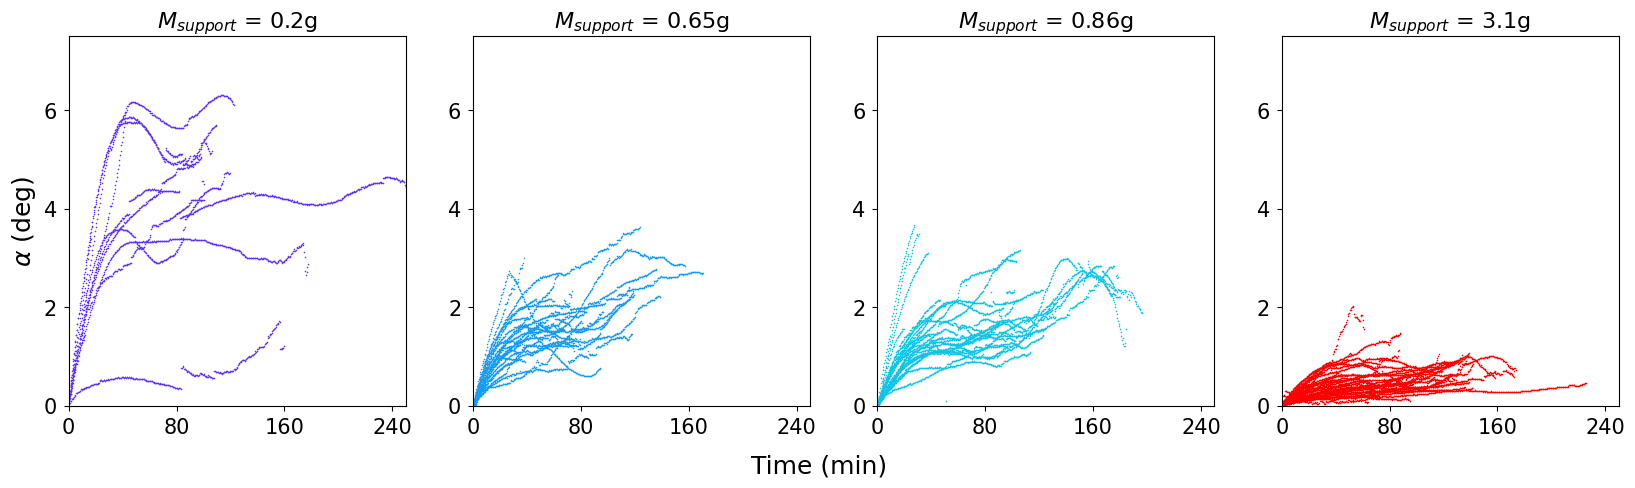

In [34]:
#%% Plot trajectories for different support masses
mass = [0.2,0.65,0.86,3.1]

fig, ax = plt.subplots(1, 4)
fig.set_figwidth(20)
fig.text(0.5, -0.03, 'Time (min)', ha='center', fontsize=fs+2)
for i in range(len(mass)):
    # ax[i].set_ylim([0, 0.125])
    ax[i].set_ylim([0, 7.5])
    # ax[i].set_xlim([0, 12500])
    ax[i].set_xlim([0, 250])
    ax[i].tick_params(axis='both', which='major', labelsize=fs-1)
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(4))
    ax[i].xaxis.set_tick_params(pad=5)
    ax[i].yaxis.set_tick_params(pad=5)
    ax[i].set_title(r'$M_{support}$'+f' = {mass[i]}g' , fontsize=fs)
ax[0].set_ylabel(r"$\alpha$ (deg)", fontsize=fs+2)
for i in range(len(events)):
    if events[i].p.m_sup in mass:
        index = mass.index(events[i].p.m_sup)
        ax[index].plot(events[i].timer/60, np.rad2deg(events[i].alpha),
                       'x',markersize=0.5,color=cmap(mass[index]/max(mass)))
#%%

Error: min_periods 1 must be <= window 0
Error: min_periods 1 must be <= window 0
Error: min_periods 1 must be <= window 0
Error: min_periods 1 must be <= window 0
Error: min_periods 1 must be <= window 0
Error: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.
Error: min_periods 1 must be <= window 0
Error: min_periods 1 must be <= window 0


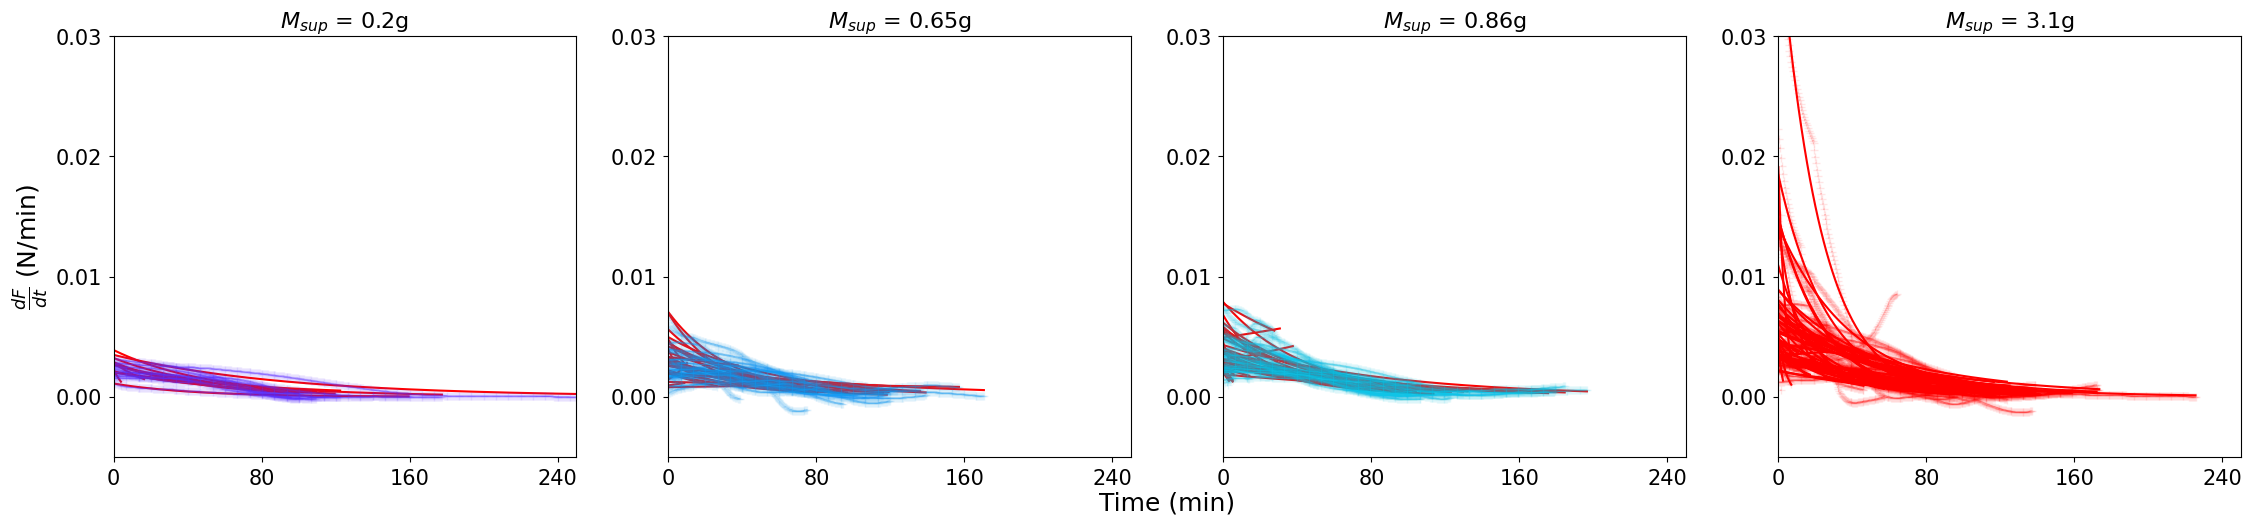

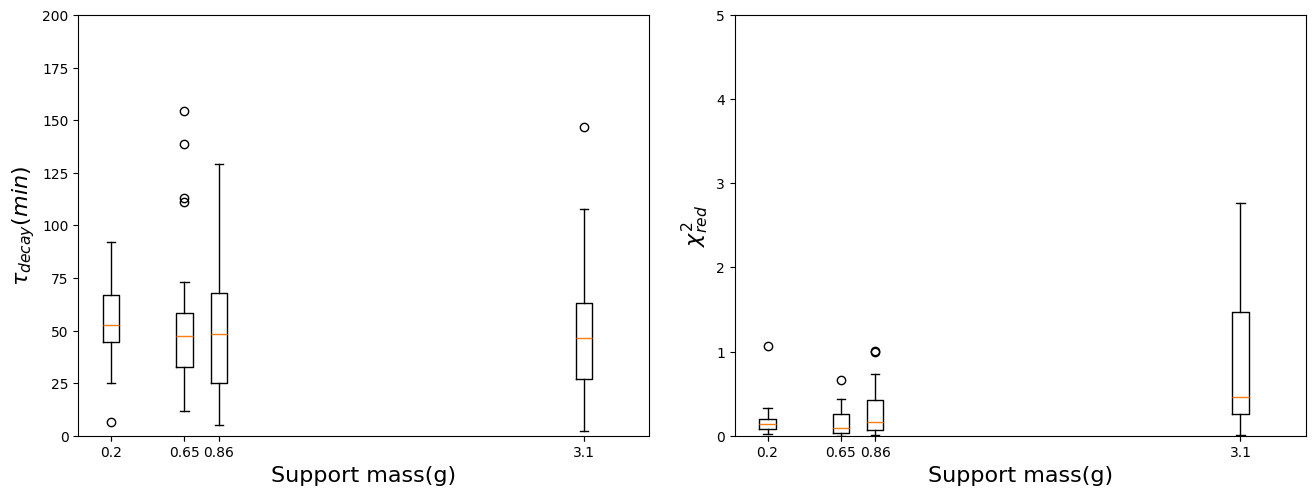

In [35]:
#%% Plot force derivative for different support masses
mass = [0.2,0.65,0.86,3.1]
# Function to apply a simple moving average for smoothing
def smooth_data_func(data, window_size=3):
    pd_data = pd.DataFrame(data)
    return pd_data.rolling(window=window_size, min_periods=1).mean()
# Smoothing iteration function
def smooth_iteration(data,window_size=3,iterations=2):
    data_smooth = smooth_data_func(data, window_size=window_size)
    for i in range(iterations-1):
        data_smooth = smooth_data_func(data_smooth, window_size=window_size)
    return data_smooth

def expfunc_core2(x, a, b):
    return a * np.exp(- b * x)

def fit_w_err(ax,x,dx,y,dy,fit_func = uf.linfunc, data_color = 'blue',
              fit_color = 'red',add_legend = False, legend_loc='best',data_alpha=0.5):
    '''Fit data to the provided function and plot with error bars.

    Parameters:
    ax : matplotlib axis object
    x, dx : array-like, data and errors in x
    y, dy : array-like, data and errors in y
    fit_func : callable, function to fit the data
    data_color : str, color for the data points
    fit_color : str, color for the fitted curve
    legend_loc : str, location for the legend
    to_print : bool, whether to print function parameters on the plot

    Returns:
    popt : array, optimal values for the parameters
    pcov : 2D array, the estimated covariance of popt
    goodness of fit: R^2 and chi^2_red
    '''
    # Plot the data with error bars
    if add_legend: label_data='Data'
    else: label_data=None
    ax.errorbar(x, y, xerr=abs(dx), yerr=abs(dy), fmt='+',
                color=data_color,label=label_data, alpha=data_alpha)
    # fit with errors via curve fit
    popt,pcov = scipy.optimize.curve_fit(fit_func, x, y,
            p0=None, sigma=np.sqrt(dx**2+dy**2), absolute_sigma=True)
    ax.plot(x,(fit_func(x,*popt)),color=fit_color,
            label='Fit')#fit_func(x,*popt))

    # goodness of fit
    ss_total = np.sum((y - np.mean(y)) ** 2)
    line_of_best_fit = popt[0] * x + popt[1] # fit_func(x, *popt)
    residuals = y - line_of_best_fit
    ss_residual = np.sum(residuals**2)
    chi_squared_red = np.sum(residuals**2 / (dy**2+dx**2))/(len(x)-3)
    chi_sr_std = np.sqrt(2/(len(x)-3))
    r_squared = 1 - (ss_residual / ss_total)
    # need to fix printing of fitted values and goodness of fit for non-linear functions:
    # ax.plot(x,popt[0]*x+popt[1],'-',color=fit_color,
    #          label=rf'$\chi^{2}={chi_squared_red:.2f}, R^{2}: {r_squared:.2f}$,\
    #                  y = {popt[0]:.2f}x + {popt[1]:.2f} ')

    # upper =(popt[0]+np.diag(pcov)[0])*x+popt[1]+np.diag(pcov)[1]
    # lower = (popt[0]-np.diag(pcov)[0])*x+popt[1]-np.diag(pcov)[1]
    # ax.fill_between(np.arange(min(x),max(x),(max(x)-min(x))/len(x)),lower,upper)
    if add_legend: ax.legend(loc=legend_loc)
    # print(rf'{popt=},{pcov=},{chi_squared_red=:.2e},{chi_sr_std=:.2e},{r_squared=:.2e}')
    return popt,pcov,r_squared,chi_squared_red

fig, ax = plt.subplots(1, 4) # plot data and fitted curves
fig.set_figwidth(22)
fig.tight_layout()
fig.text(0.5, -0.03, 'Time (min)', ha='center', fontsize=fs+2)
fig.subplots_adjust(wspace = 0.2)  # Increase space between subplots

# Setting the ylabel with different font sizes for the fraction and text
ax[0].set_ylabel(r"$\frac{dF}{dt}$ (N/min)", fontsize=fs+2)
# ax[0].set_ylabel(r"$\frac{\text{\fontsize{15}{15}\selectfont dF}}{\text{\fontsize{10}{10}\selectfont dt}}$ (N/min)", fontsize=fs + 2)
# ax[0].set_ylabel(r'$\textbf{dF}/\textbf{dt}$ (N/min)', fontsize=fs + 2)
# ax[0].set_ylabel(r"$\displaystyle\frac{dF}{dt}$ (N/min)", fontsize=fs + 2)  # Use \displaystyle for larger fraction
# ax[0].set_ylabel(r"$\frac{\text{\fontsize{15}{15}\selectfont dF}}{\text{\fontsize{10}{10}\selectfont dt}}$ (N/min)", fontsize=fs + 2) # Use \fontsize for different font sizes



fig2,ax2 = plt.subplots(1, 2) # boxplots of decay constants and chi^2_red
fig2.set_figwidth(13)
fig2.tight_layout()
fig2.subplots_adjust(wspace=0.15)  # Increase space between subplots

# Set x-ticks and labels
ax2[0].set_xticks(mass)
ax2[0].set_xticklabels(mass)
ax2[1].set_xticks(mass)
ax2[1].set_xticklabels(mass)
ax2[0].set_xlabel('Support mass(g)',fontsize=fs)
ax2[0].set_xlim([0,3.5])
ax2[0].set_ylabel(r'$\tau_{decay}(min)$',fontsize=fs)
ax2[0].set_ylim([0,200])
ax2[1].set_xlabel('Support mass(g)',fontsize=fs)
ax2[1].set_ylabel(r'$\chi^{2}_{red}$',fontsize=fs)
ax2[1].set_ylim([0,5])
ax2[1].set_xlim([0,3.5])


decay = [[] for _ in range(len(mass))]  # Initialize an empty list for each mass
chi_squared_red = [[] for _ in range(len(mass))]  # Similarly for chi_squared_red

for i in range(len(mass)):
    ax[i].set_ylim([-0.005, 0.03])
    ax[i].set_xlim([0, 250])
    ax[i].tick_params(axis='both', which='major', labelsize=fs-1)
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(4))
    ax[i].xaxis.set_tick_params(pad=5)
    ax[i].yaxis.set_tick_params(pad=5)
    ax[i].set_title(r'$M_{sup}$' + f' = {mass[i]}g', fontsize=fs)
for i in range(len(events)): 
    try:
        if events[i].p.m_sup in mass:
            index = mass.index(events[i].p.m_sup)
            df_dt = np.gradient(np.multiply(events[i].F_bean,mg2mN))
            window_proportion = 1/5 # 1/5
            n_iteration = 4 # 4
            dfdt_smooth = smooth_iteration(df_dt, window_size=int(len(df_dt)*window_proportion),iterations=n_iteration)
            fit = fit_w_err(ax[index],events[i].timer/60,0.5,dfdt_smooth[0],0.00001,fit_func = expfunc_core2,
                        data_color = cmap(mass[index]/max(mass)),fit_color = 'red',data_alpha = 0.1)
            decay[index].append(1/fit[0][1])
            chi_squared_red[index].append(fit[3])
    except Exception as e:
        print(f"Error: {e}")
        continue

# Plotting

a = ax2[0].boxplot(decay, positions=mass, widths=0.1)
a = ax2[1].boxplot(chi_squared_red, positions=mass, widths=0.1)

Error: min_periods 1 must be <= window 0
Error: min_periods 1 must be <= window 0
Error: min_periods 1 must be <= window 0
Error: min_periods 1 must be <= window 0
Error: min_periods 1 must be <= window 0
Error: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.
Error: min_periods 1 must be <= window 0
Error: min_periods 1 must be <= window 0


{'whiskers': [<matplotlib.lines.Line2D at 0x1908cc98ed0>,
 'caps': [<matplotlib.lines.Line2D at 0x1908cc9b550>,
 'boxes': [<matplotlib.lines.Line2D at 0x1908c663810>,
 'medians': [<matplotlib.lines.Line2D at 0x1908ce84650>,
 'fliers': [<matplotlib.lines.Line2D at 0x1908ce84810>,
 'means': []}

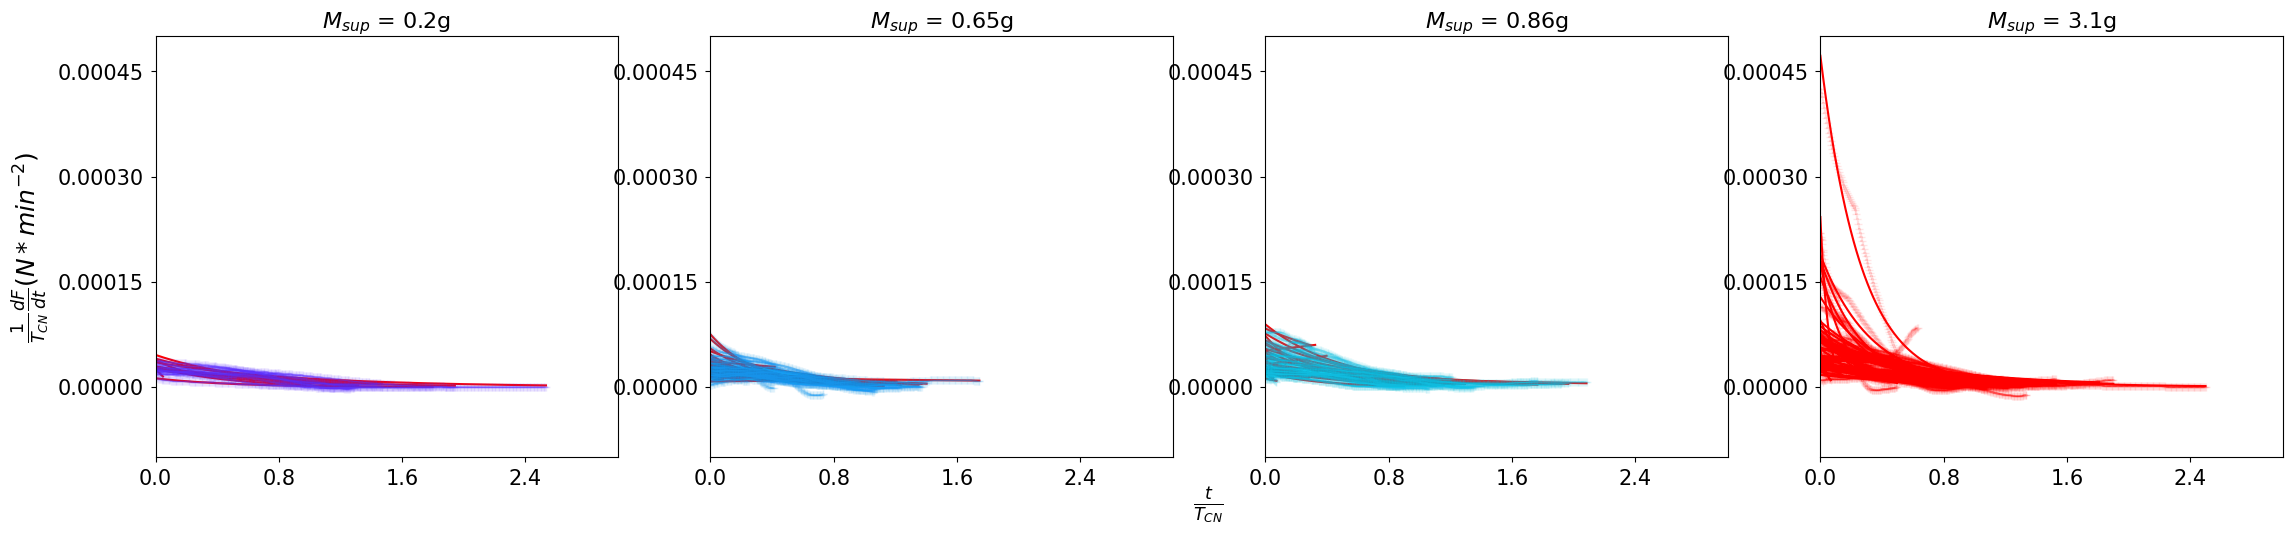

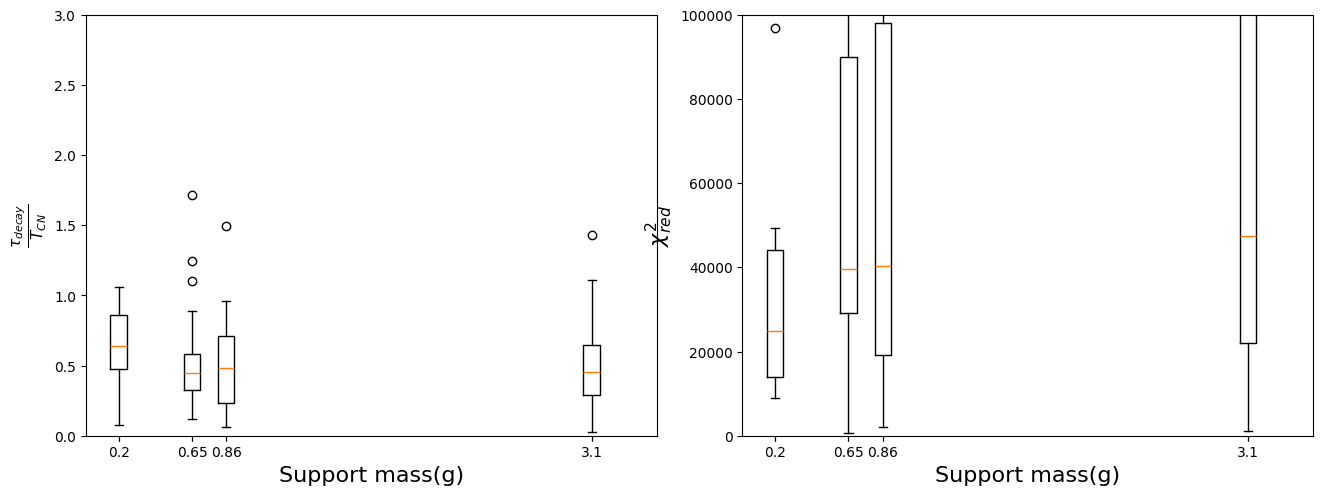

In [27]:
#%% Plot force derivative for different support masses, normalized by CN time
mass = [0.2,0.65,0.86,3.1]
fig, ax = plt.subplots(1, 4) # plot data and fitted curves
fig.set_figwidth(22)
fig.tight_layout()
fig.text(0.5, -0.03, r'$\frac{t}{T_{CN}}$', ha='center', fontsize=fs+2) # normalize by CN time
fig.subplots_adjust(wspace = 0.2)  # Increase space between subplots
ax[0].set_ylabel(r'$\frac{1}{T_{CN}}\frac{dF}{dt}(N*min^{-2})$', fontsize=fs+2)

fig2,ax2 = plt.subplots(1, 2) # boxplots of decay constants and chi^2_red
fig2.set_figwidth(13)
fig2.tight_layout()
fig2.subplots_adjust(wspace=0.15)  # Increase space between subplots

# Set x-ticks and labels
ax2[0].set_xticks(mass)
ax2[0].set_xticklabels(mass)
ax2[1].set_xticks(mass)
ax2[1].set_xticklabels(mass)
ax2[0].set_xlabel('Support mass(g)',fontsize=fs)
ax2[0].set_ylabel(r'$\frac{\tau_{decay}}{T_{CN}}$',fontsize=fs)
ax2[0].set_xlim([0,3.5])
ax2[0].set_ylim([0,3])
ax2[1].set_xlabel('Support mass(g)',fontsize=fs)
ax2[1].set_ylabel(r'$\chi^{2}_{red}$',fontsize=fs)
ax2[1].set_ylim([0,1e5])
ax2[1].set_xlim([0,3.5])


decay = [[] for _ in range(len(mass))]  # Initialize an empty list for each mass
chi_squared_red = [[] for _ in range(len(mass))]  # Similarly for chi_squared_red

for i in range(len(mass)):
    ax[i].tick_params(axis='both', which='major', labelsize=fs-1)
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(4))
    ax[i].xaxis.set_tick_params(pad=5)
    ax[i].yaxis.set_tick_params(pad=5)
    ax[i].set_title(r'$M_{sup}$' + f' = {mass[i]}g', fontsize=fs)
    ax[i].set_ylim([-0.0001, 0.0005])
    ax[i].set_xlim([0, 3])
for i in range(len(events)): 
    try:
        if events[i].p.m_sup in mass:
            index = mass.index(events[i].p.m_sup)
            window_proportion = 1/5
            n_iteration = 4
            # divide by CN time
            t = events[i].timer/60/events[i].p.avgT 
            df_dt_CNnorm = np.gradient(np.multiply(events[i].F_bean,mg2mN))/events[i].p.avgT
            # smooth and fit
            dfdt_smooth = smooth_iteration(df_dt_CNnorm, window_size=int(len(df_dt_CNnorm)*window_proportion),iterations=n_iteration)
            fit = fit_w_err(ax[index],t,0.01,dfdt_smooth[0],1e-7,fit_func = expfunc_core2,
                        data_color = cmap(mass[index]/max(mass)),fit_color = 'red',data_alpha = 0.1)
            
            decay[index].append(1/fit[0][1])
            chi_squared_red[index].append(fit[3])
    except Exception as e:
        print(f"Error: {e}")
        continue

# Plotting

ax2[0].boxplot(decay, positions=mass, widths=0.1)
ax2[1].boxplot(chi_squared_red, positions=mass, widths=0.1)

popt=array([ 0.98636788, -0.00471318]),pcov=array([[ 0.00058263, -0.00041843],
       [-0.00041843,  0.00039142]]),chi_squared_red=8.72e+00,chi_sr_std=5.00e-01,r_squared=9.60e-01


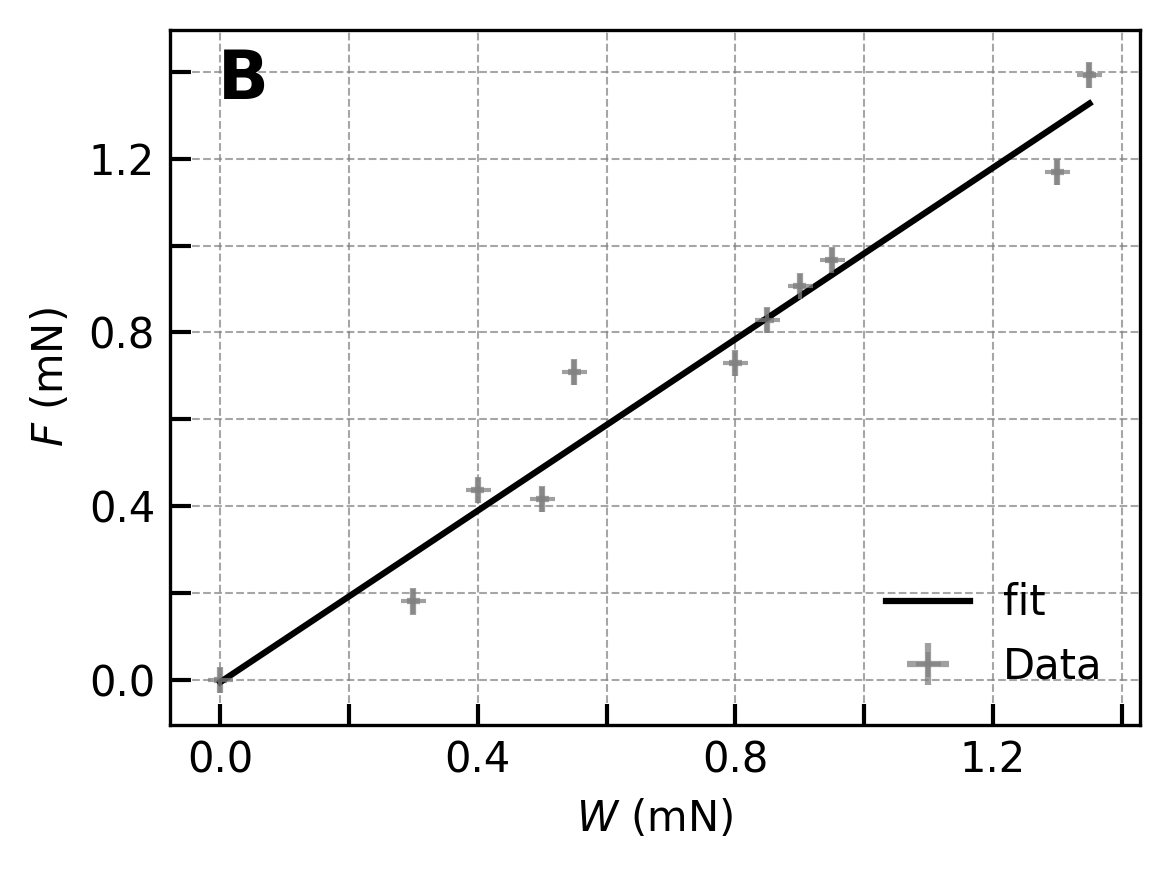

In [20]:
#%% Calibration graph for force
file = r"C:\Users\Amir\Documents\PHD\Thesis\My Articles\0 - Flexible dynamic force measurement method via physical pendulum\Data\Force calibration data 1\force_calibration_curve.xlsx"
calib_data = pd.read_excel(file)
calib_data = calib_data.dropna()

column_names = calib_data.columns
x_name = column_names[0]
y_name = column_names[1]
x = calib_data[x_name]
y = calib_data[y_name]


# plot in milli-newton: 1 dyne = 10^-5 N, 1 dyne = 100 mN
fig,ax = plt.subplots(1,1,figsize=(4, 3),dpi = 300)
ax.text(0.05, 0.9, 'B', fontsize=fs, fontweight='bold', transform=ax.transAxes)

ax = plt.gca()
x_mN = x/100
y_mN = y/100
uf.fit_w_err(ax,x_mN,0.01,y_mN,0.03,fit_func=uf.linfunc, data_color = 'gray',fit_color = 'black',data_alpha = 0.75,add_legend='measure')
plt.legend(loc='best',frameon=False)
plt.xlabel(r'$W$ (mN)')
plt.ylabel(r'$F$ (mN)')
uf.set_grid(ax,2,2)
plt.tight_layout()
plt.show()
fig.savefig(save_folder+r'\calibration.png',dpi=300)

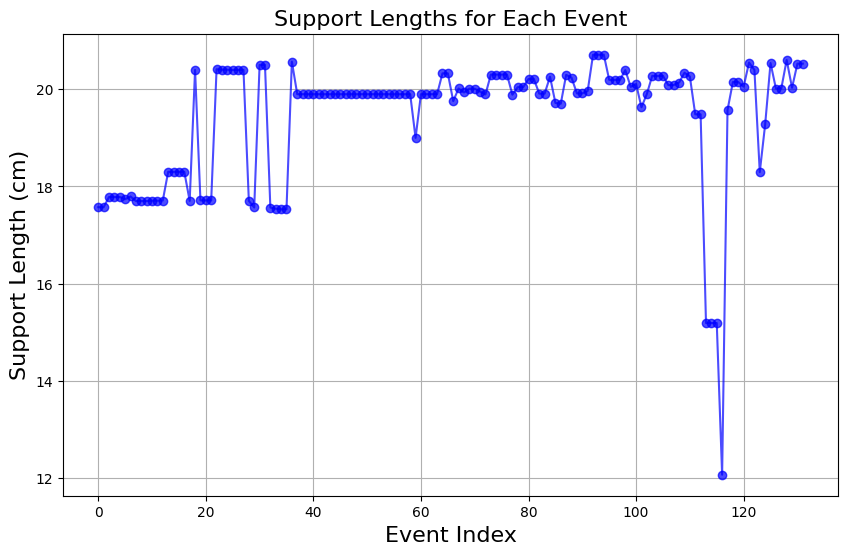

0.6283185307179586
19.485574284000002 3.1
12.063421524 0.2
19.573005596999998 0.2
20.150246592 0.2
20.150246592 0.2
20.055188376 0.2
20.55119192 0.2
20.401119024000003 0.2
18.295509828 0.2
20.541578757 0.2
20.604779734 0.2
20.529854379 0.2
20.529854379 0.2


In [165]:
# Extract support lengths from each event
support_lengths = [event.p.Lsup_cm for event in events]
# Print the variables in events
# for event in events:
    # print(vars(event.p).keys())
# Plot the support lengths
plt.figure(figsize=(10, 6))
plt.plot(support_lengths, 'o-', color='blue', alpha=0.7)
plt.xlabel('Event Index', fontsize=fs)
plt.ylabel('Support Length (cm)', fontsize=fs)
plt.title('Support Lengths for Each Event', fontsize=fs)
plt.grid(True)
plt.show()

print(2*10*m.pi/100)
k=112
print(events[k].p.Lsup_cm,events[k].p.m_sup)

for i in range(len(events)): 
        if events[i].p.m_sup < 0.5:
            print(events[i].p.Lsup_cm,events[i].p.m_sup)


df_w=1.00e-02,df_L=3.09e-05,df_l_contact=3.09e-05,df_alpha=1.09e-01
dF=3.45e-01
F_calc_mg=5.56e+00


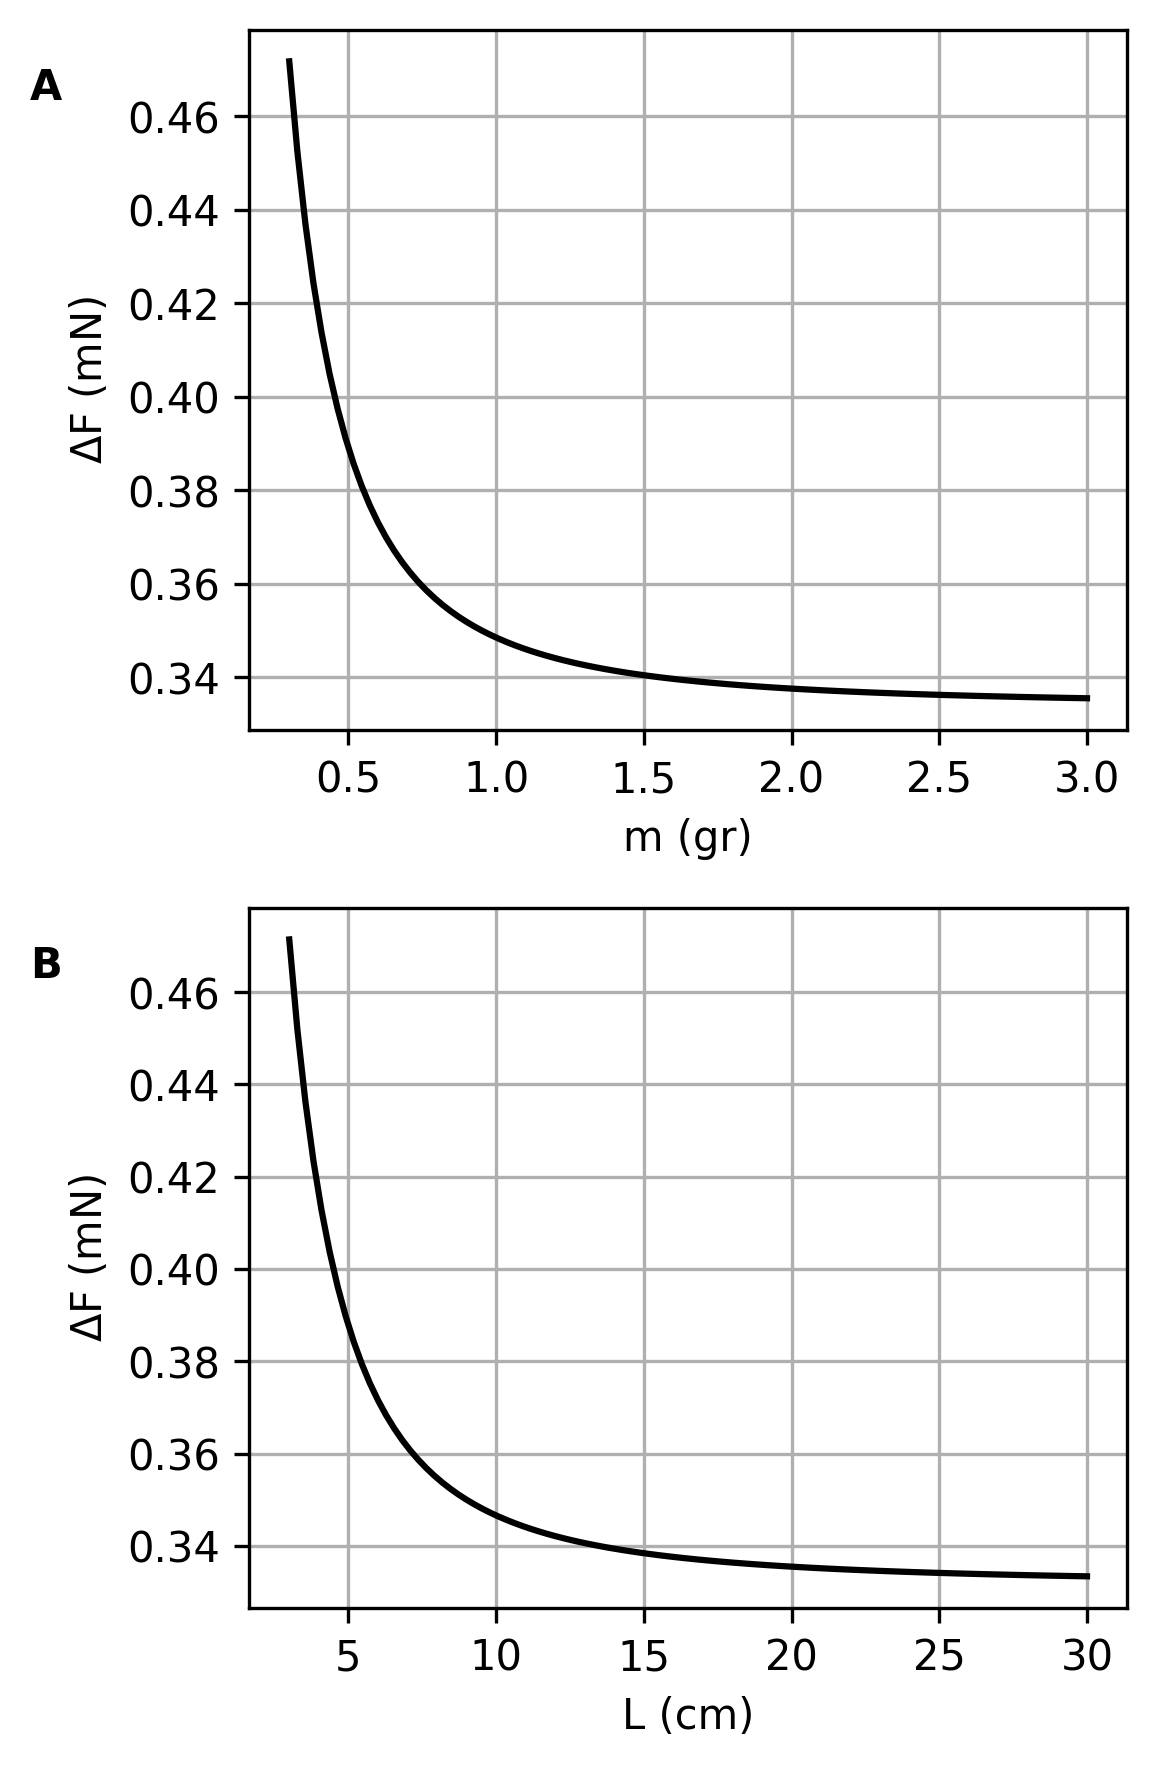

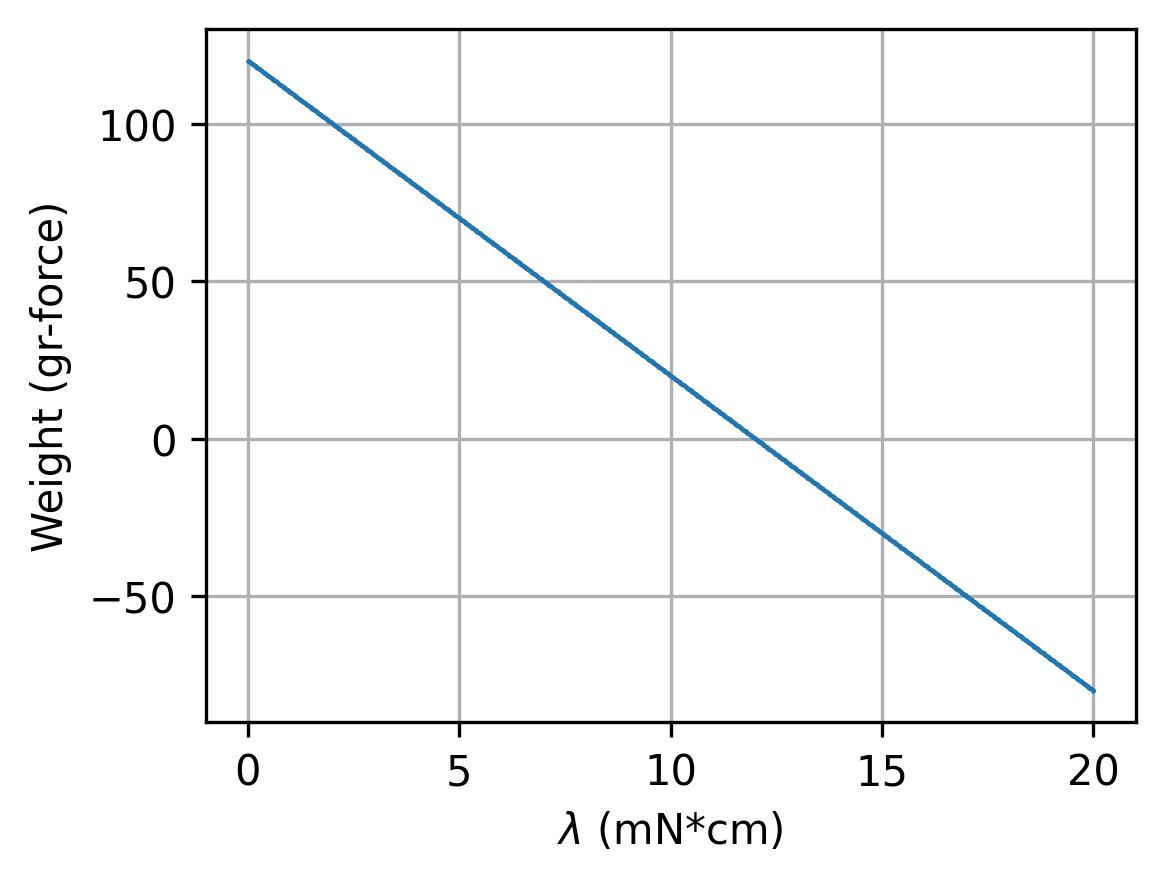

In [16]:
# Error calculations
import math as m
w = 1 # gr
dw = 0.01 # gr
g = 981 # cm/s^2
L = 20 # cm
L_vec = np.linspace(3, 30, 100) # rod length vec in cm
w_vec = np.linspace(0.3, 3, 100) # rod mass vec in gr
dL = 0.1 # cm
l_contact = 2 # cm
dl_contact = 0.01 # cm
alpha = 0.01 # rad
dalpha = 0.00033 # rad
F = 10 # 10 gr, 0.1 mN


# Error in force
df_w = ((F/w)**2)*(dw)**2
df_L = ((F/L)**2)*(((L*l_contact-2*L+2*l_contact)/(2*(L-l_contact)))**2)*(dL)**2
df_l_contact =((F/(L-l_contact))**2)*(dl_contact)**2
df_alpha = (((F/m.tan(alpha)+F*m.tan(alpha)))**2)*(dalpha)**2
dF = m.sqrt(df_w+df_L+df_l_contact+df_alpha)
print(f'{df_w=:.2e},{df_L=:.2e},{df_l_contact=:.2e},{df_alpha=:.2e}')
print(f'{dF=:.2e}')


# gcgs=980
# F_mg = 1000*m_sup * l_sup_cm * m.tan(phi_t)/(2*(l_sup_cm-d_contact))
F_calc_mg = 1000*w * L * m.tan(alpha)/(2*(L-l_contact))
print(f'{F_calc_mg=:.2e}') # force in  milli-grams
# the force applied by bean stem in milligrams(!)
# to get the force in dyne-> *gcgs=980 cm/s^2

# plot errors in force as function of m and L, assume others are const
l_contact = 0 # cm
fig,ax = plt.subplots(2,1,figsize=(4, 6),dpi = 300)
ax[0].text(-0.25, 0.9, 'A', fontweight='bold', transform=ax[0].transAxes)
ax[1].text(-0.25, 0.9, 'B', fontweight='bold', transform=ax[1].transAxes)
# Calculate dF as a function of w_vec
dF_w_vec = []
for w in w_vec:
    df_w = ((F/w)**2)*(dw)**2
    df_L = ((F/L)**2)*(((L*l_contact-2*L+2*l_contact)/(2*(L-l_contact)))**2)*(dL)**2
    df_l_contact =((F/(L-l_contact))**2)*(dl_contact)**2
    df_alpha = (((F/m.tan(alpha)+F*m.tan(alpha)))**2)*(dalpha)**2
    dF_w_vec.append(m.sqrt(df_w+df_L+df_l_contact+df_alpha))

# Plot dF as a function of w_vec
ax[0].plot(w_vec, dF_w_vec, color = 'black', label='dF vs w')
ax[0].set_xlabel('m (gr)')
ax[0].set_ylabel(r'$\Delta$F (mN)')
# ax[0].legend()
ax[0].grid(True)

# Calculate dF as a function of L_vec
dF_L_vec = []
for L in L_vec:
    df_w = ((F/w)**2)*(dw)**2
    df_L = ((F/L)**2)*(((L*l_contact-2*L+2*l_contact)/(2*(L-l_contact)))**2)*(dL)**2
    df_l_contact =((F/(L-l_contact))**2)*(dl_contact)**2
    df_alpha = (((F/m.tan(alpha)+F*m.tan(alpha)))**2)*(dalpha)**2
    dF_L_vec.append(m.sqrt(df_w+df_L+df_l_contact+df_alpha))

# Plot dF as a function of L_vec
ax[1].plot(L_vec, dF_L_vec, color = 'black', label='dF vs L')
ax[1].set_xlabel('L (cm)')
ax[1].set_ylabel(r'$\Delta$F (mN)')
# ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()
fig.savefig(save_folder+r'\dfdmdfdL.png',dpi=300)

# estimate maximal mass for given force, res, and length
sigma_res = 0.01 # cm
F = 0.1 # mN
lambda_noise = np.linspace(0, 20, 1000)# noise level: [F][L] = [mN][cm]
max_mg = (4*L*F-lambda_noise)/sigma_res # in mN
fig,ax = plt.subplots(1,1,figsize=(4, 3),dpi = 300)
ax.plot(lambda_noise,max_mg/10,'x',markersize=0.5)
ax.set_xlabel(r'$\lambda$ (mN*cm)')
ax.set_ylabel('Weight (gr-force)') # 1mN ~ 0.1 gram-force
ax.grid(True)


Calculate the ambient fluctuations over 2 minutes, with a 1sec interval \
get standard deviation and mean

50
['2619.0', ' 1991.0', ' 144.0', ' 116.0', ' C:\\Users\\Amir\\Documents\\PHD\\Experiments\\Force Measurements\\Exp2_Pendulum\\Calibrations\\fluctuations_1sec_int\\DSC_8205.JPG', ' 2024-05-11 13:07', ' 0', ' Auto\n']
100
['2640.0', ' 1994.0', ' 120.0', ' 97.0', ' C:\\Users\\Amir\\Documents\\PHD\\Experiments\\Force Measurements\\Exp2_Pendulum\\Calibrations\\fluctuations_1sec_int\\DSC_8255.JPG', ' 2024-05-11 13:08', ' 0', ' Auto\n']
pix2cm=0.0019 cm/pix,std_noise=0.096 mm
h_tip=1.1 cm
d_alpha_noise=0.00029 rad , np.rad2deg(d_alpha_noise)=0.016 deg
D_mm=20 mm,dD_mm=0.11 mm,L_mm=1.8e+02 mm,dL_mm=0.053 mm,h_tip_mm=11 mm,      dh_tip_mm=0.053 mm,A=0.059,alpha_error_calc=0.00033 rad, F_min_mN=0.0013 mN


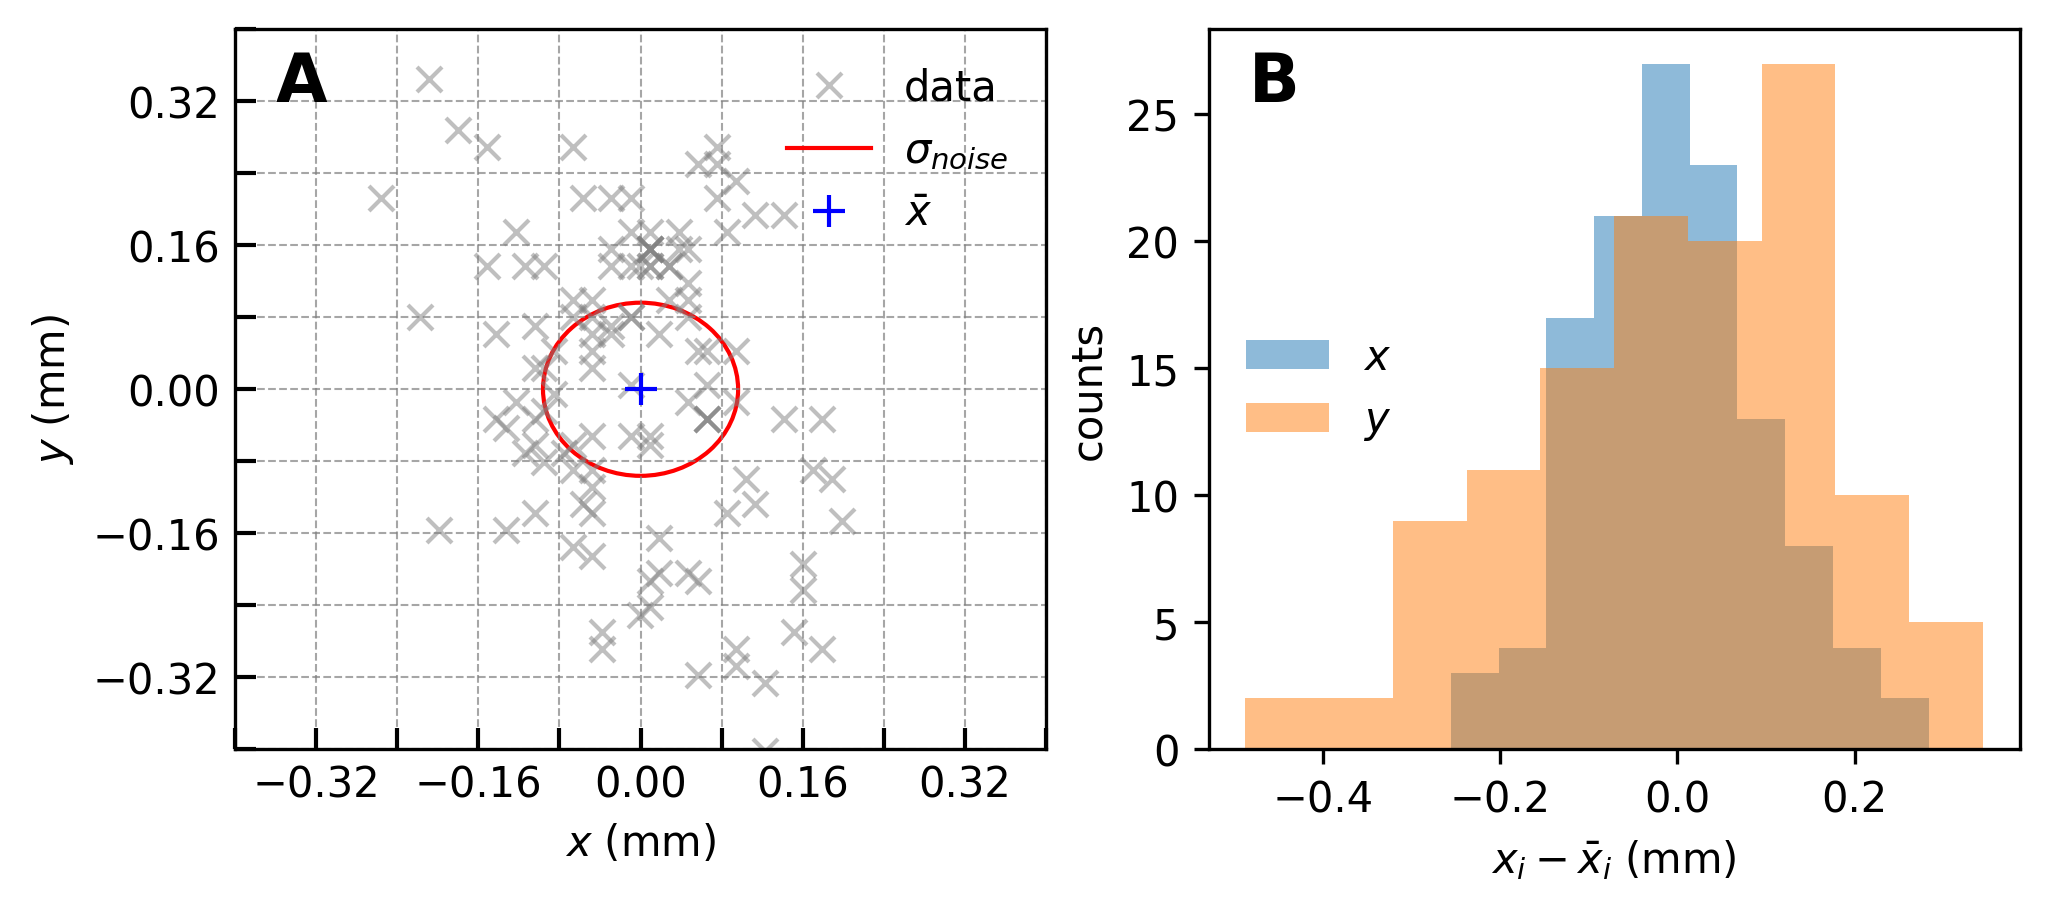

In [36]:
# noise plots 1

from matplotlib.lines import Line2D


def funcget_tracked_data(filename,view=[],camera='nikon'):
    '''get tracked data from file, return x,y,t, index, N- # of lines, C-max tracked obj,T-# of points per track'''
    with open(filename,"r") as datafile:
        lines= datafile.readlines()
        # del lines[0] # remove first line to avoid 2 zero times
        N=np.size(lines,0) # number of lines
        xtl=[[]]*N # x top left
        ytl=[[]]*N # y top left
        w=[[]]*N # box width
        h=[[]]*N # box height
        xcntr=[[]]*N # box x center
        ycntr=[[]]*N # box y center
        timer = np.zeros(N) # initialize timer array
        timer[0]=0 # time starts at zero
        i=0 # count rows
    # x,y,w,h ; start at upper left corner
        for line in lines:
            if line==[]: break
            currentline = line.split(",") # split by ','
            xtl[i]=float(currentline[0]) # xtl- x top left
            ytl[i]=float(currentline[1])
            w[i]=float(currentline[2])
            h[i]=float(currentline[3])
            xcntr[i]=xtl[i]+w[i]/2 # calculate x coordinate of box center
            ycntr[i]=ytl[i]-h[i]/2
            i+=1
            if i%50 ==0: 
                print(i)
                print(currentline)

        # timer = np.zeros(N) # initialize timer array
        dt = 1 # interval
        for i in range(N):
            timer[i] = timer[i-1]+dt # assign timer value for each index
        return xcntr,ycntr,timer,index,N
    
test = r"C:\Users\Amir\Documents\PHD\Python\GitHub\Amir_Repositories\Repo_article0\CSRT_fluctuations_1sec_interval.txt"
xcntr,ycntr,timer,index,N = funcget_tracked_data(test)
pend_diam_pix = 423 # width of the pendulum from top view
pend_diam_cm = 0.8
L_cm = 18 
pix2cm = pend_diam_cm/pend_diam_pix 
L_mm = L_cm*10
h_tip = np.mean([events[i].L_track2suptip_cm for i in range(len(events))])
h_tip_mm = h_tip*10

fig, ax = plt.subplots(1, 2, figsize=(7, 3), dpi=300)
ax[0].text(0.05, 0.9, 'A', fontsize=fs, fontweight='bold', transform=ax[0].transAxes)
ax[1].text(0.05, 0.9, 'B', fontsize=fs, fontweight='bold', transform=ax[1].transAxes)

x = np.subtract(xcntr, np.mean(xcntr))*pix2cm*10 # x10 for mm
y = np.subtract(ycntr, np.mean(ycntr))*pix2cm*10 # x10 for mm
ax[0].plot(x,y,'x',color='grey',alpha=0.5,label = 'data')
ax[0].plot(np.mean(x),np.mean(y),'b+',markersize=7.5,label={r'$\bar{x}$'})
# Calculate the standard deviation of the points
std_noise = np.std(np.sqrt(x**2 + y**2)) # in mm

# Plot a thin red circle with a radius of the standard deviation around the mean

circle_noise = plt.Circle((np.mean(x), np.mean(y)), std_noise, color='red', fill=False, linewidth=1,label=r'$\sigma_{noise}$')
# Plot a thin red circle with a radius of the pendulum around the mean
circle_diameter = plt.Circle((np.mean(x), np.mean(y)), pend_diam_cm/2*10, color='red', fill=False, linewidth=0.5)
# plt.gca().add_artist(circle_diameter)
ax[0].add_artist(circle_noise)

# Create a custom legend element for the noise and data
legend_elements = [
    Line2D([0], [0], marker='x', color='grey', alpha=0.5, linestyle='None', label='data'),  # Data points
    Line2D([0], [0], color='red', lw=1, linestyle='-', label=r'$\sigma_{noise}$'),  # Straight red line
    Line2D([0], [0], marker='+', color='blue', markersize=7.5, linestyle='None', label=r'$\bar{x}$') # mean point
]

# Add the custom legend elements to the plot
ax[0].legend(handles=legend_elements, loc='best', frameon=False)
ax[0].set_ylim([-0.4,0.4])
ax[0].set_xlim([-0.4,0.4])
# plt.ylim([-4.5,4.5])
# plt.xlim([-4.5,4.5])
ax[0].set_xlabel(r'$x$ (mm)')
ax[0].set_ylabel(r'$y$ (mm)')
# ax[0].show()

print(f'{pix2cm=:.2g} cm/pix,{std_noise=:.2g} mm')

ax[1].hist(x,alpha=0.5,label=r'$x$')
ax[1].hist(y,alpha=0.5,label=r'$y$')
ax[1].set_xlabel(r'$x_{i} - \bar{x}_{i}$ (mm)')
ax[1].set_ylabel('counts')  
ax[1].legend(loc='best', frameon=False)
print(f'{h_tip=:.2g} cm')

d_alpha_noise = m.asin((std_noise/2)/(L_mm-h_tip_mm))
print(f'{d_alpha_noise=:.2g} rad , {np.rad2deg(d_alpha_noise)=:.2g} deg')

# error from resolution:
# distance error is ssq of individual measurement errors ~ 2 pixels per measurement ?
err_res_pix = m.sqrt(2**2 + 2**2)
err_res_mm = err_res_pix*pix2cm*10

# d_alpha_res = m.asin((err_res_mm/2)/(L_mm-h_tip_mm))
# print(f'{d_alpha_res=:.2g} rad , {np.rad2deg(d_alpha_res)=:.2g} deg')


# sum errors from resolution and noise:
# d_alpha_tot = m.sqrt(d_alpha_res**2+d_alpha_noise**2) # deg
# print(f'{d_alpha_tot=:.2g} rad , {np.rad2deg(d_alpha_tot)=:.2g} deg')
D_mm = 20 # mean deflection in mm 
dD_mm = np.sqrt(std_noise**2 + (err_res_pix*pix2cm*10)**2) # in mm
dh_tip_mm = err_res_pix*pix2cm*10
dL_mm = err_res_pix*pix2cm*10
A = D_mm/(2*(L_mm-h_tip_mm))
alpha_error_calc = 1/(1-A**2)*np.sqrt((A*dD_mm/D_mm)**2+(A*dL_mm/(L_mm-h_tip_mm))**2+(A* dh_tip_mm/(L_mm-h_tip_mm))**2)
F_min_mg = 1000*0.8 * m.tan(alpha_error_calc)/2
F_min_mN = F_min_mg * 1e-2
print(f'{D_mm=:.2g} mm,{dD_mm=:.2g} mm,{L_mm=:.2g} mm,{dL_mm=:.2g} mm,{h_tip_mm=:.2g} mm,\
      {dh_tip_mm=:.2g} mm,{A=:.2g},{alpha_error_calc=:.2g} rad, {F_min_mN=:.2g} mN')

uf.set_grid(ax[0],0.8,0.8)
# uf.set_grid(ax[1],1,25)

# adjust layout and show
# fig.subplots_adjust(wspace=0.4)  # Adjust the width space between subplotsplt.tight_layout()
fig.subplots_adjust(top=0.95, bottom=0.15, left=0.1, right=0.95)  # Adjust as necessary

fig.savefig(save_folder+r'\noise.png',dpi=300)

50
['2619.0', ' 1991.0', ' 144.0', ' 116.0', ' C:\\Users\\Amir\\Documents\\PHD\\Experiments\\Force Measurements\\Exp2_Pendulum\\Calibrations\\fluctuations_1sec_int\\DSC_8205.JPG', ' 2024-05-11 13:07', ' 0', ' Auto\n']
100
['2640.0', ' 1994.0', ' 120.0', ' 97.0', ' C:\\Users\\Amir\\Documents\\PHD\\Experiments\\Force Measurements\\Exp2_Pendulum\\Calibrations\\fluctuations_1sec_int\\DSC_8255.JPG', ' 2024-05-11 13:08', ' 0', ' Auto\n']
pix2cm=0.0019 cm/pix,std_noise=0.096 mm
d_alpha_noise=0.00029 rad , np.rad2deg(d_alpha_noise)=0.016 deg
D_mm=20 mm,dD_mm=0.11 mm,L_mm=1.8e+02 mm,dL_mm=0.053 mm,h_tip_mm=11 mm,      dh_tip_mm=0.053 mm,A=0.059,alpha_error_calc=0.00033 rad, F_min_mN=0.0013 mN


C:\Users\Amir\AppData\Local\Temp\ipykernel_25024\591337905.py:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


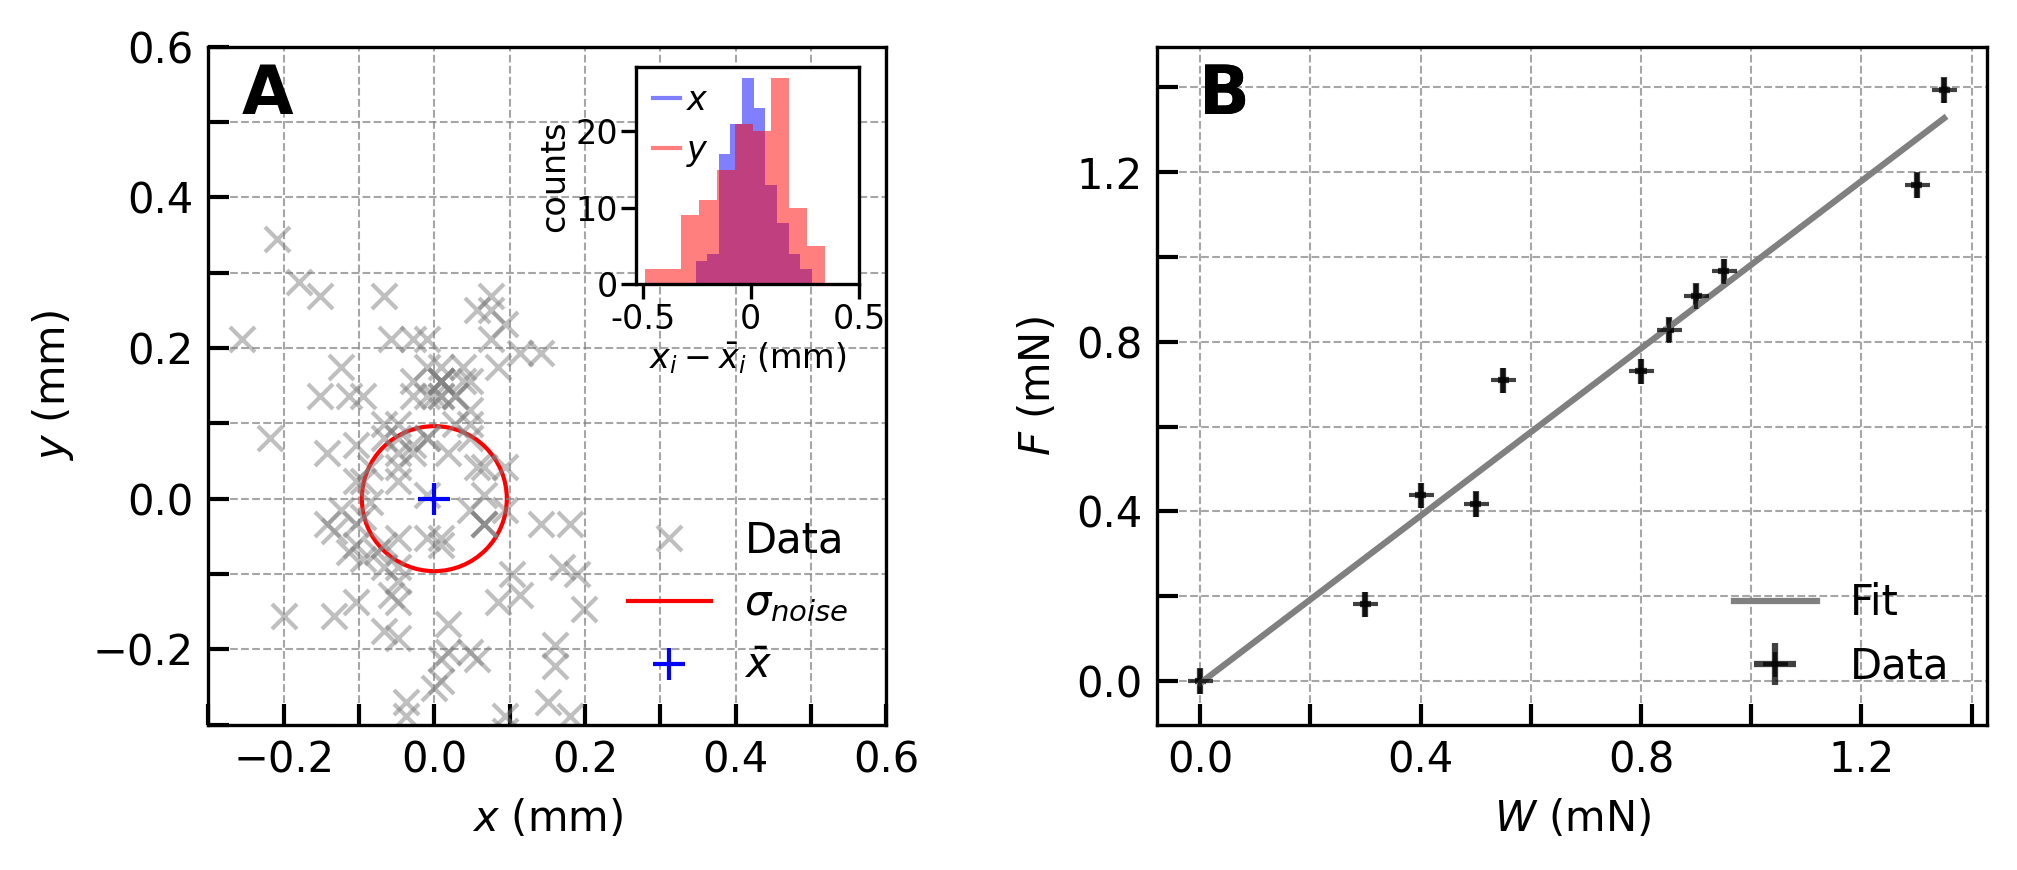

In [37]:
# combined plot of calibration and noise

from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def funcget_tracked_data(filename,view=[],camera='nikon'):
    '''get tracked data from file, return x,y,t, index, N- # of lines, C-max tracked obj,T-# of points per track'''
    with open(filename,"r") as datafile:
        lines= datafile.readlines()
        # del lines[0] # remove first line to avoid 2 zero times
        N=np.size(lines,0) # number of lines
        xtl=[[]]*N # x top left
        ytl=[[]]*N # y top left
        w=[[]]*N # box width
        h=[[]]*N # box height
        xcntr=[[]]*N # box x center
        ycntr=[[]]*N # box y center
        timer = np.zeros(N) # initialize timer array
        timer[0]=0 # time starts at zero
        i=0 # count rows
    # x,y,w,h ; start at upper left corner
        for line in lines:
            if line==[]: break
            currentline = line.split(",") # split by ','
            xtl[i]=float(currentline[0]) # xtl- x top left
            ytl[i]=float(currentline[1])
            w[i]=float(currentline[2])
            h[i]=float(currentline[3])
            xcntr[i]=xtl[i]+w[i]/2 # calculate x coordinate of box center
            ycntr[i]=ytl[i]-h[i]/2
            i+=1
            if i%50 ==0: 
                print(i)
                print(currentline)

        # timer = np.zeros(N) # initialize timer array
        dt = 1 # interval
        for i in range(N):
            timer[i] = timer[i-1]+dt # assign timer value for each index
        return xcntr,ycntr,timer,index,N
    
test = r"C:\Users\Amir\Documents\PHD\Python\GitHub\Amir_Repositories\Repo_article0\CSRT_fluctuations_1sec_interval.txt"
xcntr,ycntr,timer,index,N = funcget_tracked_data(test)
pend_diam_pix = 423 # width of the pendulum from top view
pend_diam_cm = 0.8
L_cm = 18 
pix2cm = pend_diam_cm/pend_diam_pix 
L_mm = L_cm*10
h_tip = np.mean([events[i].L_track2suptip_cm for i in range(len(events))])
h_tip_mm = h_tip*10

fig, ax = plt.subplots(1, 2, figsize=(7, 3), dpi=300)
ax[0].text(0.05, 0.9, 'A', fontsize=fs, fontweight='bold', transform=ax[0].transAxes)
ax[1].text(0.05, 0.9, 'B', fontsize=fs, fontweight='bold', transform=ax[1].transAxes)

x = np.subtract(xcntr, np.mean(xcntr))*pix2cm*10 # x10 for mm
y = np.subtract(ycntr, np.mean(ycntr))*pix2cm*10 # x10 for mm
ax[0].plot(x,y,'x',color='grey',alpha=0.5,label = 'Data')
ax[0].plot(np.mean(x),np.mean(y),'b+',markersize=7.5,label={r'$\bar{x}$'})
# Calculate the standard deviation of the points
std_noise = np.std(np.sqrt(x**2 + y**2)) # in mm

# Plot a thin red circle with a radius of the standard deviation around the mean

circle_noise = plt.Circle((np.mean(x), np.mean(y)), std_noise, color='red', fill=False, linewidth=1,label=r'$\sigma_{noise}$')
# Plot a thin red circle with a radius of the pendulum around the mean
circle_diameter = plt.Circle((np.mean(x), np.mean(y)), pend_diam_cm/2*10, color='red', fill=False, linewidth=0.5)
# plt.gca().add_artist(circle_diameter)
ax[0].add_artist(circle_noise)

# Create a custom legend element for the noise and data
legend_elements = [
    Line2D([0], [0], marker='x', color='grey', alpha=0.5, linestyle='None', label='Data'),  # Data points
    Line2D([0], [0], color='red', lw=1, linestyle='-', label=r'$\sigma_{noise}$'),  # Straight red line
    Line2D([0], [0], marker='+', color='blue', markersize=7.5, linestyle='None', label=r'$\bar{x}$') # mean point
]

# Add the custom legend elements to the plot
ax[0].legend(handles=legend_elements, loc='lower right', frameon=False)
ax[0].set_ylim([-0.2,0.4])
ax[0].set_xlim([-0.2,0.4])
# plt.ylim([-4.5,4.5])
# plt.xlim([-4.5,4.5])
ax[0].set_xlabel(r'$x$ (mm)')
ax[0].set_ylabel(r'$y$ (mm)')
# ax[0].show()


# errors
print(f'{pix2cm=:.2g} cm/pix,{std_noise=:.2g} mm')
d_alpha_noise = m.asin((std_noise/2)/(L_mm-h_tip_mm))
print(f'{d_alpha_noise=:.2g} rad , {np.rad2deg(d_alpha_noise)=:.2g} deg')
# error from resolution:
# distance error is ssq of individual measurement errors ~ 2 pixels per measurement
err_res_pix = m.sqrt(2**2 + 2**2)
err_res_mm = err_res_pix*pix2cm*10

# sum errors from resolution and noise:
D_mm = 20 # mean deflection in mm 
dD_mm = np.sqrt(std_noise**2 + (err_res_pix*pix2cm*10)**2) # in mm
dh_tip_mm = err_res_pix*pix2cm*10
dL_mm = err_res_pix*pix2cm*10
A = D_mm/(2*(L_mm-h_tip_mm))
alpha_error_calc = 1/(1-A**2)*np.sqrt((A*dD_mm/D_mm)**2+(A*dL_mm/(L_mm-h_tip_mm))**2+(A* dh_tip_mm/(L_mm-h_tip_mm))**2)
F_min_mg = 1000*0.8 * m.tan(alpha_error_calc)/2
F_min_mN = F_min_mg * 1e-2
print(f'{D_mm=:.2g} mm,{dD_mm=:.2g} mm,{L_mm=:.2g} mm,{dL_mm=:.2g} mm,{h_tip_mm=:.2g} mm,\
      {dh_tip_mm=:.2g} mm,{A=:.2g},{alpha_error_calc=:.2g} rad, {F_min_mN=:.2g} mN')

uf.set_grid(ax[0],1,1)
# Increase the x and y scales of the main plot
ax[0].set_xlim([-0.3, 0.6])
ax[0].set_ylim([-0.3, 0.6])
# Ensure the x and y axes are plotted on the same scale
ax[0].set_aspect('equal', adjustable='box')


# Create inset of the distribution plot
# Create inset axes
ax_inset = inset_axes(ax[0], width="40%", height="40%",# loc='upper right',
                      bbox_to_anchor=(0.17, 0.2,0.82,0.8), bbox_transform=ax[0].transAxes)
# Plot the distribution on the inset
ax_inset.hist(x, alpha=0.5, color='blue', label=r'$x$')
ax_inset.hist(y, alpha=0.5, color='red', label=r'$y$')
ax_inset.set_xlabel(r'$x_{i} - \bar{x}_{i}$ (mm)',fontsize=8,labelpad=1)
ax_inset.set_ylabel('counts',fontsize=8,labelpad=1)
# Control x-tick and y-tick positions
ax_inset.set_xticks([-0.5, 0, 0.5])  # Set specific tick positions
ax_inset.set_xticklabels([-0.5, 0, 0.5], fontsize=8)  # Set specific tick labels with fontsize
ax_inset.set_yticks([0, 10, 20])  # Set specific y-tick positions
ax_inset.set_yticklabels([0, 10, 20], fontsize=8)  # Set specific y-tick labels with fontsize
# Adjust tick labels' padding
ax_inset.tick_params(axis='x', pad=1)  # Move x-axis labels closer to the ticks
ax_inset.tick_params(axis='y', pad=1)  # Move y-axis labels closer to the ticks
# Create a custom legend element for the noise distribution
legend_elements = [
    Line2D([0], [0], color='blue',alpha=0.5, lw=1, linestyle='-', label=r'$x$'),  # Data points
    Line2D([0], [0], color='red', lw=1, alpha=0.5, linestyle='-', label=r'$y$'),  # Straight red line
]

# Adjust the legend properties
ax_inset.legend(
    handles=legend_elements,
    loc='upper left',          # Place in the upper-right corner
    frameon=False,              # Remove the frame
    handlelength=0.8,             # Shorter line elements
    handletextpad=0.2,          # Reduce space between handle and text
    borderaxespad=0.1,          # Reduce space between legend and inset plot edge
    fontsize=8                  # Smaller font size for better fit
)

#%% Calibration graph for force
file = r"C:\Users\Amir\Documents\PHD\Thesis\My Articles\0 - Flexible dynamic force measurement method via physical pendulum\Data\Force calibration data 1\force_calibration_curve.xlsx"
calib_data = pd.read_excel(file)
calib_data = calib_data.dropna()

column_names = calib_data.columns
x_name = column_names[0]
y_name = column_names[1]
x = calib_data[x_name]
y = calib_data[y_name]


# plot in milli-newton: 1 dyne = 10^-5 N, 1 dyne = 100 mN
ax[1].text(0.05, 0.9, 'B', fontsize=fs, fontweight='bold', transform=ax[1].transAxes)
x_mN = x/100
y_mN = y/100
fit_w_err(ax[1],x_mN,0.01,y_mN,0.03,fit_func=uf.linfunc, data_color = 'black',fit_color = 'gray',data_alpha = 0.75,add_legend='measure')
ax[1].legend(loc='best',frameon=False)
ax[1].set_xlabel(r'$W$ (mN)')
ax[1].set_ylabel(r'$F$ (mN)')
uf.set_grid(ax[1],2,2)


plt.tight_layout()
plt.show()

# adjust layout and show
# fig.subplots_adjust(wspace=0.4)  # Adjust the width space between subplotsplt.tight_layout()
fig.subplots_adjust(top=0.95, bottom=0.15, left=0.1, right=0.95)  # Adjust as necessary

fig.savefig(save_folder+r'\calibration and noise.png',dpi=300)

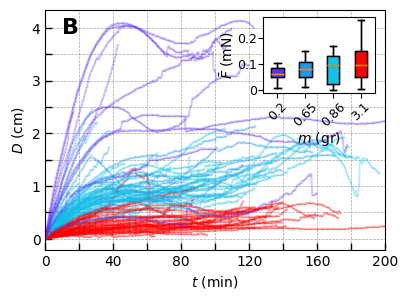

In [39]:
#%% Rod displacement and mean force and per rod mass
from matplotlib.lines import Line2D

cmap = plt.get_cmap('rainbow')
mass = [0.2,0.65,0.86,3.1]
# mass = [0.2,0.65,0.86,1.1, 3.1]

# Create the figure
fig, axs = plt.subplots(1, 1, figsize=(4, 3))
# fig.align_labels()  # Align labels for all subplots
# add subplot labels
axs.text(0.05, 0.9, 'B', fontsize=fs, fontweight='bold', transform=axs.transAxes)
# axs[1].text(0.05, 0.9, 'B', fontsize=fs, fontweight='bold', transform=axs[1].transAxes)

# all events displacements
for i in range(len(events)):
    if events[i].p.m_sup in mass:
        index = mass.index(events[i].p.m_sup)
        axs.plot(events[i].timer/60, events[i].trk_dist ,marker=
                    'x',markersize=0.5,color=cmap(mass[index]/max(mass)),alpha=0.25)

# set grid and labels of main plot
uf.set_grid(axs,200,5)
axs.set_xlim([0,200])
axs.set_xlabel(r'$t$ (min)')
axs.set_ylabel(r'$D$ (cm)') #,fontsize=fs)

# Ensure the x and y axes are plotted on the same scale
# axs.set_aspect('equal', adjustable='box')

# mean force boxplot for all events (upto the first 2 hours)
f_mean = [[] for i in range(len(mass))]
for i in range(len(events)):
    
    if events[i].p.m_sup in mass:
        index = mass.index(events[i].p.m_sup)
        f_mean[index].append(np.mean(np.multiply(events[i].F_bean,mg2mN)))

# Create inset axes
ax_inset = inset_axes(axs, width="40%", height="40%",# loc='upper right',
                      bbox_to_anchor=(0.17, 0.2,0.82,0.8), bbox_transform=axs.transAxes)
ax_inset.boxplot(f_mean, positions=range(len(mass))) # to space the ticks by mass

box_colors = [cmap(mass[i] / max(mass)) for i in range(len(mass))]
box = ax_inset.boxplot(f_mean, patch_artist=True, positions=range(len(mass)))
for patch, color in zip(box['boxes'], box_colors):
    patch.set_facecolor(color)


# Create inset of the distribution plot
ax_inset.set_xticks(range(len(mass)))
ax_inset.set_xticklabels([f'{m}' for m in mass], rotation=45)#, ha='right')
ax_inset.set_ylabel(r'$\bar{F}$ (mN)',fontsize=10,labelpad=1)
ax_inset.set_xlabel(r'$m$ (gr)',fontsize=10,labelpad=1)

# Control x-tick and y-tick positions
# ax_inset.set_xticks(mass)  # Set specific tick positions
ax_inset.set_xticklabels(mass, fontsize=9)  # Set specific tick labels with fontsize
ax_inset.set_yticks([0, 0.1, 0.2])  # Set specific y-tick positions
ax_inset.set_yticklabels([0, 0.1, 0.2], fontsize=9)  # Set specific y-tick labels with fontsize
# Adjust tick labels' padding
ax_inset.tick_params(axis='x', pad=1)  # Move x-axis labels closer to the ticks
ax_inset.tick_params(axis='y', pad=1)  # Move y-axis labels closer to the ticks
# Create a custom legend element for the noise distribution
# legend_elements = [Line2D([0], [0], color=cmap(mass[i]/max(mass)), lw=2, label=f'{mass[i]}') for i in range(len(mass))]
# fig.legend(handles=legend_elements, bbox_to_anchor=(0.25, 0.75), 
#            ncol=1, title='Rod Mass (gr)',fontsize=8, handlelength=1.5,
#            borderaxespad=0.1,frameon=False)

# Add color bar to the left of the main plot
# norm = plt.Normalize(min(mass), max(mass))
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# Create an inset axis for the color bar
# cbar_ax = inset_axes(axs, width="5%", height="100%", loc='center left',
#                     bbox_to_anchor=(-0.25, 0, 1, 1), bbox_transform=axs.transAxes,
#                     borderpad=0)
# cbar = fig.colorbar(sm, cax=cbar_ax)
# Set ticks to appear on the left
# cbar.ax.yaxis.set_ticks_position('left')
# cbar.set_label('Mass (g)', fontsize=10)
# cbar_ax.set_title('Rod Mass (gr)', fontsize=10)

# Adjust the legend properties
# fig.legend(
#     handles=legend_elements,
#     loc='upper left',          # Place in the upper-right corner
#     frameon=False,              # Remove the frame
#     handlelength=0.8,             # Shorter line elements
#     handletextpad=0.2,          # Reduce space between handle and text
#     borderaxespad=0.1,          # Reduce space between legend and inset plot edge
#     fontsize=8                  # Smaller font size for better fit
# )

# adjust layout and show
# fig.subplots_adjust(wspace=0.4)  # Adjust the width space between subplotsplt.tight_layout()
# fig.subplots_adjust(top=0.8, bottom=0.1, left=0.1, right=0.9)  # Adjust as necessary

fig.subplots_adjust(top=0.95, bottom=0.15, left=0.1, right=0.95)  # Adjust as necessary
plt.show()
fig.savefig(save_folder+r'\D_Fmean_msup.png',dpi=300)